# Исследование развлекательного приложения Procrastinate Pro+

## Введение

### Описание проекта

Развлекательное приложения Procrastinate Pro+ вкладывает огромные деньги в рекламу, однако последние несколько месяцев компания терпит убытки. 

###### Цель исследования — разобраться в причинах убытков и помочь компании выйти в плюс.

Для этого исследуем данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. Данные включают:

* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

В рамках исследования изучим:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

### Описание данных

В вашем распоряжении три датасета. 

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.

Структура costs_info_short.csv:
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.

### План работы над проектом

1. Загрузка данных и их предподготовка к анализу
2. Введение функций для расчёта и анализа LTV, ROI, удержания и конверсии
3. Исследовательский анализ данных
4. Маркетинг
5. Оценка окупаемости рекламы
6. Выводы

## Основная часть

### Загрузка данных и их предподготовка к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`. 
- расходы: `/datasets/costs_info_short.csv`. 

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
# Импортируем библиотеки pandas для открытия и изучения исходных данных.

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import requests
import re
import math
from scipy import stats as st
from math import factorial
from scipy.stats import binom
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cохраним исходные данные в переменную games

try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
    
except:
    visits = pd.read_csv('https://_____visits_info_short.csv')
    orders = pd.read_csv('https://____orders_info_short.csv')
    costs = pd.read_csv('https://_____costs_info_short.csv')
    
# Выведем первые 5 строк для обзора данных.
display(visits.head(5))
display(orders.head(5))
display(costs.head(5))

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

#### Исправление заголовков

Заголовки в таблицах не соответствуют правилам хорошего кода, переименуем их. 

In [3]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id','event_dt', 'revenue']
costs.columns = costs.columns.str.lower()

display(visits.head(5))
display(orders.head(5))
display(costs.head(5))

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

#### Проверка наличия дубликатов и пропусков

In [4]:
# Приведем все текстовые значения к нижнему регистру для поиска неявных дубликатов
visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel'] = visits['channel'].str.lower()
costs['channel'] = costs['channel'].str.lower()

display(visits)
display(costs)

user_id         region   device         channel  \
0       981449118918  united states   iphone         organic   
1       278965908054  united states   iphone         organic   
2       590706206550  united states      mac         organic   
3       326433527971  united states  android          tiptop   
4       349773784594  united states      mac         organic   
...              ...            ...      ...             ...   
309896  329994900775             uk       pc         leapbob   
309897  334903592310         france       pc  lambdamediaads   
309898  540102010126        germany       pc         organic   
309899  308736936846        germany      mac         organic   
309900  109329042535        germany       pc  lambdamediaads   

              session_start          session_end  
0       2019-05-01 02:36:01  2019-05-01 02:45:01  
1       2019-05-01 04:46:31  2019-05-01 04:47:35  
2       2019-05-01 14:09:25  2019-05-01 15:32:08  
3       2019-05-01 00:29:59  2019-05-01 00:54:25  
4       2019-05-01 03:33:35  2019-05-01 03:57:40  
...                     ...                  ...  
309896  2019-10-31 13:28:12  2019-10-31 14:39:29  
309897  2019-10-31 22:14:52  2019-10-31 22:39:36  
309898  2019-10-31 01:40:48  2019-10-31 01:41:31  
309899  2019-10-31 07:37:34  2019-10-31 07:37:55  
309900  2019-10-31 14:17:43  2019-10-31 15:17:04  

[309901 rows x 6 columns]

dt         channel  costs
0     2019-05-01        faceboom  113.3
1     2019-05-02        faceboom   78.1
2     2019-05-03        faceboom   85.8
3     2019-05-04        faceboom  136.4
4     2019-05-05        faceboom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdamediaads    4.0
1796  2019-10-24  lambdamediaads    6.4
1797  2019-10-25  lambdamediaads    8.8
1798  2019-10-26  lambdamediaads    8.8
1799  2019-10-27  lambdamediaads   12.0

[1800 rows x 3 columns]

In [5]:
print('Количество дубликатов в колонке visits:', visits.duplicated().sum())
print('Количество дубликатов в колонке orders:', orders.duplicated().sum())
print('Количество дубликатов в колонке costs:', costs.duplicated().sum())

Количество дубликатов в колонке visits: 0
Количество дубликатов в колонке orders: 0
Количество дубликатов в колонке costs: 0


In [6]:
# Посмотрим какие уникальные значения есть в таблице visits

display(visits['region'].unique().tolist())
display(visits['device'].unique().tolist())
display(visits['channel'].unique().tolist())
display(orders['revenue'].unique().tolist())
display(costs['channel'].unique().tolist())
display(costs['costs'].unique().tolist())

['united states', 'uk', 'france', 'germany']

['iphone', 'mac', 'android', 'pc']

['organic',
 'tiptop',
 'rocketsuperads',
 'yrabbit',
 'faceboom',
 'mediatornado',
 'adnonsense',
 'leapbob',
 'wahoonetbanner',
 'opplecreativemedia',
 'lambdamediaads']

[4.99, 5.99, 9.99, 49.99, 19.99]

['faceboom',
 'mediatornado',
 'rocketsuperads',
 'tiptop',
 'yrabbit',
 'adnonsense',
 'leapbob',
 'opplecreativemedia',
 'wahoonetbanner',
 'lambdamediaads']

[113.3,
 78.10000000000001,
 85.80000000000001,
 136.4,
 122.1,
 118.8,
 101.2,
 100.1,
 93.5,
 104.5,
 132.0,
 105.6,
 92.4,
 110.0,
 117.7,
 128.70000000000002,
 99.0,
 88.0,
 115.5,
 97.9,
 82.5,
 140.8,
 91.3,
 107.8,
 169.4,
 178.20000000000002,
 213.4,
 214.50000000000003,
 234.3,
 159.5,
 147.4,
 138.60000000000002,
 143.0,
 193.6,
 135.3,
 163.9,
 124.3,
 114.4,
 176.0,
 210.1,
 158.4,
 144.10000000000002,
 171.60000000000002,
 174.9,
 258.5,
 232.1,
 237.6,
 217.8,
 227.7,
 235.4,
 255.2,
 264.0,
 242.00000000000003,
 233.2,
 204.6,
 240.9,
 194.7,
 179.3,
 168.3,
 156.20000000000002,
 134.20000000000002,
 182.6,
 160.60000000000002,
 123.20000000000002,
 90.2,
 108.9,
 145.20000000000002,
 189.2,
 141.9,
 133.10000000000002,
 206.8,
 198.00000000000003,
 167.20000000000002,
 161.70000000000002,
 218.9,
 261.8,
 216.7,
 229.9,
 155.10000000000002,
 188.1,
 205.7,
 192.50000000000003,
 152.9,
 228.8,
 225.50000000000003,
 203.50000000000003,
 191.4,
 211.2,
 207.9,
 221.1,
 183

Аномалий в значениях категориальных столбцах нет. В колонке costs таблицы 'costs' некоторые значения имеют множетство нулей после запятой. Округлим все значенияю до одной цифры после запятой.

In [7]:
costs['costs'] = round(costs['costs'], 1)
display(costs['costs'].unique().tolist())

[113.3,
 78.1,
 85.8,
 136.4,
 122.1,
 118.8,
 101.2,
 100.1,
 93.5,
 104.5,
 132.0,
 105.6,
 92.4,
 110.0,
 117.7,
 128.7,
 99.0,
 88.0,
 115.5,
 97.9,
 82.5,
 140.8,
 91.3,
 107.8,
 169.4,
 178.2,
 213.4,
 214.5,
 234.3,
 159.5,
 147.4,
 138.6,
 143.0,
 193.6,
 135.3,
 163.9,
 124.3,
 114.4,
 176.0,
 210.1,
 158.4,
 144.1,
 171.6,
 174.9,
 258.5,
 232.1,
 237.6,
 217.8,
 227.7,
 235.4,
 255.2,
 264.0,
 242.0,
 233.2,
 204.6,
 240.9,
 194.7,
 179.3,
 168.3,
 156.2,
 134.2,
 182.6,
 160.6,
 123.2,
 90.2,
 108.9,
 145.2,
 189.2,
 141.9,
 133.1,
 206.8,
 198.0,
 167.2,
 161.7,
 218.9,
 261.8,
 216.7,
 229.9,
 155.1,
 188.1,
 205.7,
 192.5,
 152.9,
 228.8,
 225.5,
 203.5,
 191.4,
 211.2,
 207.9,
 221.1,
 183.7,
 148.5,
 170.5,
 195.8,
 173.8,
 248.6,
 299.2,
 236.5,
 243.1,
 294.8,
 295.9,
 290.4,
 260.7,
 259.6,
 222.2,
 262.9,
 238.7,
 201.3,
 172.7,
 180.4,
 154.0,
 200.2,
 272.8,
 6.2,
 5.0,
 7.0,
 9.4,
 11.0,
 9.6,
 8.9,
 6.7,
 8.6,
 11.5,
 7.2,
 11.3,
 8.4,
 6.5,
 8.2,
 5.8,
 7.9,
 

In [8]:
display(visits.isna().sum())
display(orders.isna().sum())
costs.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

Пропусков в исследуемых таблицах нет. 

#### Исправление типа файлов

In [9]:
# выведем основную информацию о количестве значений и типе данных
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Колонки с датами имеют тип object. Чтобы было удобнее с ними работать переведем их в тип datetime.
Колонки region, device и channel в таблицах visits и costs имеют ограниченное количество вариантов значений, переведем ихв тип 'category'.

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

visits['region'] = visits['region'].astype('category')
visits['device'] = visits['device'].astype('category')
visits['channel'] = visits['channel'].astype('category')
costs['channel'] = costs['channel'].astype('category')

In [11]:
# выведем основную информацию о количестве значений и типе данных
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  category      
 2   device         309901 non-null  category      
 3   channel        309901 non-null  category      
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: category(3), datetime64[ns](2), int64(1)
memory usage: 8.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   dt       1800 non-null   object  
 1   channel  1800 non-null   category
 2   costs    1800 non-null   float64 
dtypes: category(1), float64(1), object(1)
memory usage: 30.4+ KB


None

In [12]:
# У колонки dt в таблице costs  тип данных остался object. Это нам не помешает. поэтому оставим как есть.

display(costs['dt'].unique().tolist())

[datetime.date(2019, 5, 1),
 datetime.date(2019, 5, 2),
 datetime.date(2019, 5, 3),
 datetime.date(2019, 5, 4),
 datetime.date(2019, 5, 5),
 datetime.date(2019, 5, 6),
 datetime.date(2019, 5, 7),
 datetime.date(2019, 5, 8),
 datetime.date(2019, 5, 9),
 datetime.date(2019, 5, 10),
 datetime.date(2019, 5, 11),
 datetime.date(2019, 5, 12),
 datetime.date(2019, 5, 13),
 datetime.date(2019, 5, 14),
 datetime.date(2019, 5, 15),
 datetime.date(2019, 5, 16),
 datetime.date(2019, 5, 17),
 datetime.date(2019, 5, 18),
 datetime.date(2019, 5, 19),
 datetime.date(2019, 5, 20),
 datetime.date(2019, 5, 21),
 datetime.date(2019, 5, 22),
 datetime.date(2019, 5, 23),
 datetime.date(2019, 5, 24),
 datetime.date(2019, 5, 25),
 datetime.date(2019, 5, 26),
 datetime.date(2019, 5, 27),
 datetime.date(2019, 5, 28),
 datetime.date(2019, 5, 29),
 datetime.date(2019, 5, 30),
 datetime.date(2019, 5, 31),
 datetime.date(2019, 6, 1),
 datetime.date(2019, 6, 2),
 datetime.date(2019, 6, 3),
 datetime.date(2019, 6, 4)

#### Вывод

Провели предобработку данных, подготовили их к анализу. Заголовки столццов исправили в соответствии с правилами хорошего кода.Типы данных изменили на category и datetime. Пропусков и дубликатов не выявлено.

### Введение функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Ниже зададим функции, которые мы будем использовать в дальнейшем исследовании.

#### Функция создания профилей пользователей — get_profiles()

In [13]:
 # функция для создания пользовательских профилей

def get_profiles(sessions, orders, advert_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    advert_costs = advert_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    advert_costs['acquisition_cost'] = advert_costs['costs'] / advert_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        advert_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция подсчета коэфициента удержания подсчёта — get_retention()

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция подсчета конверсии — get_сonversion()

In [15]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция подсчета Livetime value и ROI — get_ltv()

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция сглаживания данных

In [17]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция построения графика удержания (Retention Rate)

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция построения графика конверсии 

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция визуализации LTV и ROI

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Профили пользователей 

In [21]:
# Составим профили пользователей.
# Вызываем функцию get_profiles и передаем в нее данные о посещениях, заказах и расходах на рекламу -visits, orders, costs.

profiles = get_profiles(visits, orders, costs)
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      faceboom     mac  united states   
1            4919697 2019-07-09 12:46:07      faceboom  iphone  united states   
2            6085896 2019-10-01 09:58:33       organic  iphone         france   
3           22593348 2019-08-22 21:35:48    adnonsense      pc        germany   
4           31989216 2019-10-02 00:07:44       yrabbit  iphone  united states   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        tiptop  iphone  united states   
150004  999975439887 2019-10-21 00:35:17       organic      pc             uk   
150005  999976332130 2019-07-23 02:57:06        tiptop  iphone  united states   
150006  999979924135 2019-09-28 21:28:09  mediatornado      pc  united states   
150007  999999563947 2019-10-18 19:57:25       organic  iphone  united states   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.204762  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

In [22]:
# Определяем минимальную и максимальную даты привлечения пользователей

min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max() 

print('Минимальная дата первого привличения пользователя:', min_analysis_date) 
print('Максимальная дата первого привличения пользователя:', observation_date)

Минимальная дата первого привличения пользователя: 2019-05-01
Максимальная дата первого привличения пользователя: 2019-10-27


###### Вывод
Составлена таблица с профилями 150 007 пользователей. В каждом профиле есть данные: 

* о дате первого посещения приложения (first_ts), 
* рекламном источнике, который мотивировал пользователя установить приложение (channel); 
* тип устройства пользователя (device); 
* страна пользователя (region); 
* дата первого посещения приложения (dt); 
* первый день месяца, в который это посещение произошло (month); 
* признак платящих пользователей (True - платящий, False - неплатящий); 
* стоимость привлечения пользователя (acquisition_cost).

Минимальная дата первого привличения пользователя: 1 мая 2019 года

Максимальная дата первого привличения пользователя: 27 октября 2019 года

#### Пользователи и плательщики по странам

country  quantity_users  quantity_payers  percent_users  \
3  united states          100002             6902          66.66   
2             uk           17575              700          11.72   
0         france           17450              663          11.63   
1        germany           14981              616           9.99   

   percent_payers  percent_payers_in_users  
3           77.72                     6.90  
2            7.88                     3.98  
0            7.47                     3.80  
1            6.94                     4.11

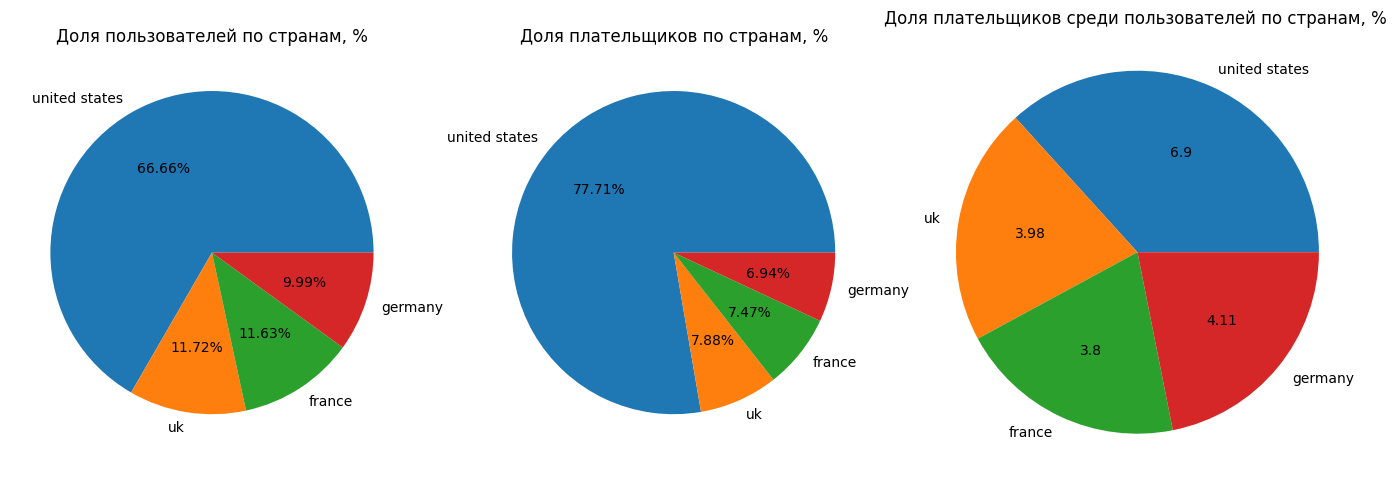

In [23]:
# сгрупируем данные по регионам, посчитаем количество юзеров и плательщиков в каждой стране
user_in_country = profiles.groupby('region').agg({'user_id': 'count', 'payer': 'sum'}).reset_index()

# переименуем столбцы, чтобы убрать двуэтажные заголовки
user_in_country.columns = ['country', 'quantity_users', 'quantity_payers']

# создадим столбцы с долей пользователей по странам и долей плательщиков в каждой стране

user_in_country['percent_users'] = round((user_in_country['quantity_users']/user_in_country['quantity_users'].sum()*100), 2)
user_in_country['percent_payers'] = round((user_in_country['quantity_payers']/user_in_country['quantity_payers'].sum()*100), 2)
user_in_country['percent_payers_in_users'] = round((user_in_country['quantity_payers']/user_in_country['quantity_users']*100), 2)

# отсортируем страны по уменьщению доли
user_in_country = user_in_country.sort_values(by='percent_payers', ascending=False)

# Напечатаем таблицу c данными
display(user_in_country)

# построим график с двумя круговыми диаграммами 
fig, ax = plt.subplots(1, 3, figsize = (14, 5)) 

# увеличим расстояние между графиками
fig.tight_layout()

# Круговая диаграмма показывает доли в процентах.
# создаем функцию, чтобы вывести на круговую диаграмму фактические данные колонки percent_payers_among_users, 
# т.к. в ней мы уже посчитали нужные нам доли 
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 2)
    return a

ax[0].pie(
    user_in_country['percent_users'], 
    labels=user_in_country['country'], 
    autopct='%.2f%%'
)
ax[0].set_title('Доля пользователей по странам, %')

ax[1].pie(
    user_in_country['percent_payers'], 
    labels=user_in_country['country'], 
    autopct='%.2f%%'
)
ax[1].set_title('Доля плательщиков по странам, %')


# создаем переменную для функции absolute_value (абсолютные значения для круговой диаграммы)
sizes = user_in_country['percent_payers_in_users']

ax[2].pie(
    user_in_country['percent_payers_in_users'], 
    labels=user_in_country['country'],
# применяем созданную функцию absolute_value к параметру autopct
    autopct=absolute_value
)

ax[2].set_title('Доля плательщиков среди пользователей по странам, %')
plt.axis('equal')

plt.show()

###### Вывод
У мобильного приложения имеются пользователи из 4 стран - США, Великобритании, Франции и Германии. 

Больше всего плательщиков (77,70%) и пользователей приложения (66,66%) - из США. Доля плательщиков в пользователях 6,9%.

Оставшиеся три страны показывают схожие данные, разница в пределах 2 процентов.

На втором месте по количеству плательщиков (7,94%) и пользователей (11,72%) - Великобритания.

На третьем месте - Франция: 7,43% плательщиков и 11,63% пользователей.

На четвертом месте Германия - 6,93% плательщиков, 9,99% от всех пользователей.

У США огромный отрыв от других стран по количеству пользователей и плательщиков, но по доле плательщиков среди юзеров отрыв не такой большой. Можно рекомендовать разработчикам усилить конверсию юзеров США в плательщиков - это может дать значительный прирост выручки.

Также отметим, что Германия по доле плательщиков среди пользователей приложения занимает второе место после США (4,11%). Это свидетельствует о лучшей, чем в Британии и Франции, конвертации пользователей в плательщиков.

#### Устройства пользователей и плательщиков

device  quantity_users  quantity_payers  percent_users  percent_payers  \
1   iphone           54479             3382          36.32           38.08   
0  android           35032             2050          23.35           23.08   
2      mac           30042             1912          20.03           21.53   
3       pc           30455             1537          20.30           17.31   

   percent_payers_in_users  
1                     6.21  
0                     5.85  
2                     6.36  
3                     5.05

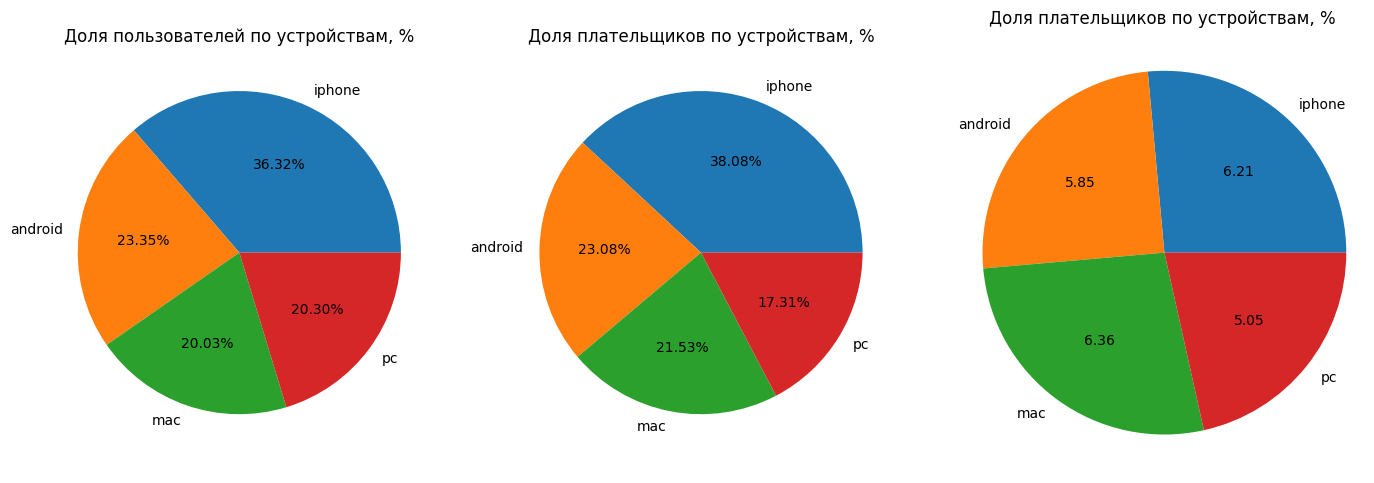

In [24]:
# сгрупируем данные по устройствам, посчитаем количество юзеров и плательщиков 
user_devices = profiles.groupby('device').agg({'user_id': 'count', 'payer': 'sum'}).reset_index()

# переименуем столбцы
user_devices.columns = ['device', 'quantity_users', 'quantity_payers']

# создадим столбцы с долей пользователей и плательщиков по устройствам

user_devices['percent_users'] = round((user_devices['quantity_users']/user_devices['quantity_users'].sum()*100), 2)
user_devices['percent_payers'] = round((user_devices['quantity_payers']/user_devices['quantity_payers'].sum()*100), 2)
user_devices['percent_payers_in_users'] = round((user_devices['quantity_payers']/user_devices['quantity_users']*100), 2)

# отсортируем страны по уменьщению доли плательщиков
user_devices = user_devices.sort_values(by='percent_payers', ascending=False)

# Напечатаем таблицу c данными
display(user_devices)

# построим график с двумя круговыми диаграммами 
fig, ax = plt.subplots(1, 3, figsize = (14, 5)) 

# увеличим расстояние между графиками
fig.tight_layout()

ax[0].pie(
    user_devices['percent_users'], 
    labels=user_devices['device'], 
    autopct='%.2f%%'
)
ax[0].set_title('Доля пользователей по устройствам, %')

ax[1].pie(
    user_devices['percent_payers'], 
    labels=user_devices['device'],
# применяем созданную функцию absolute_value к параметру autopct
    autopct='%.2f%%'
)

ax[1].set_title('Доля плательщиков по устройствам, %')


# создаем переменную для функции absolute_value (абсолютные значения для круговой диаграммы)
sizes = user_devices['percent_payers_in_users']

ax[2].pie(
    user_devices['percent_payers_in_users'], 
    labels=user_devices['device'],
# применяем созданную функцию absolute_value к параметру autopct
    autopct=absolute_value
)

ax[2].set_title('Доля плательщиков по устройствам, %')
plt.axis('equal')

plt.show()

###### Вывод
Платящие пользователи предпочитают iphone - 38,08% среди всех платящих. Эта же платформа является самой популярной среди всех пользователей приложения (36,22%).

Далее по популярности среди плательщиков идут устройства android (23,08%), mac (21,53%) и pc (17,31%). 

Mac (6,36%) и iphone (6,21%) - лидеры по доле платящих среди всех пользователей. То есть пользователи этих устройств лучше конвертируются в плательщиков.

#### Источники привлечения плательщиков 


channel  quantity_users  quantity_payers  percent_users  \
1             faceboom           29144             3557          19.43   
8               tiptop           19561             1878          13.04   
6              organic           56439             1160          37.62   
9       wahoonetbanner            8553              453           5.70   
0           adnonsense            3880              440           2.59   
7       rocketsuperads            4448              352           2.97   
3              leapbob            8553              262           5.70   
5   opplecreativemedia            8605              233           5.74   
2       lambdamediaads            2149              225           1.43   
10             yrabbit            4312              165           2.87   
4         mediatornado            4364              156           2.91   

    percent_payers  percent_payers_in_users  
1            40.05                    12.20  
8            21.15                     9.60  
6            13.06                     2.06  
9             5.10                     5.30  
0             4.95                    11.34  
7             3.96                     7.91  
3             2.95                     3.06  
5             2.62                     2.71  
2             2.53                    10.47  
10            1.86                     3.83  
4             1.76                     3.57

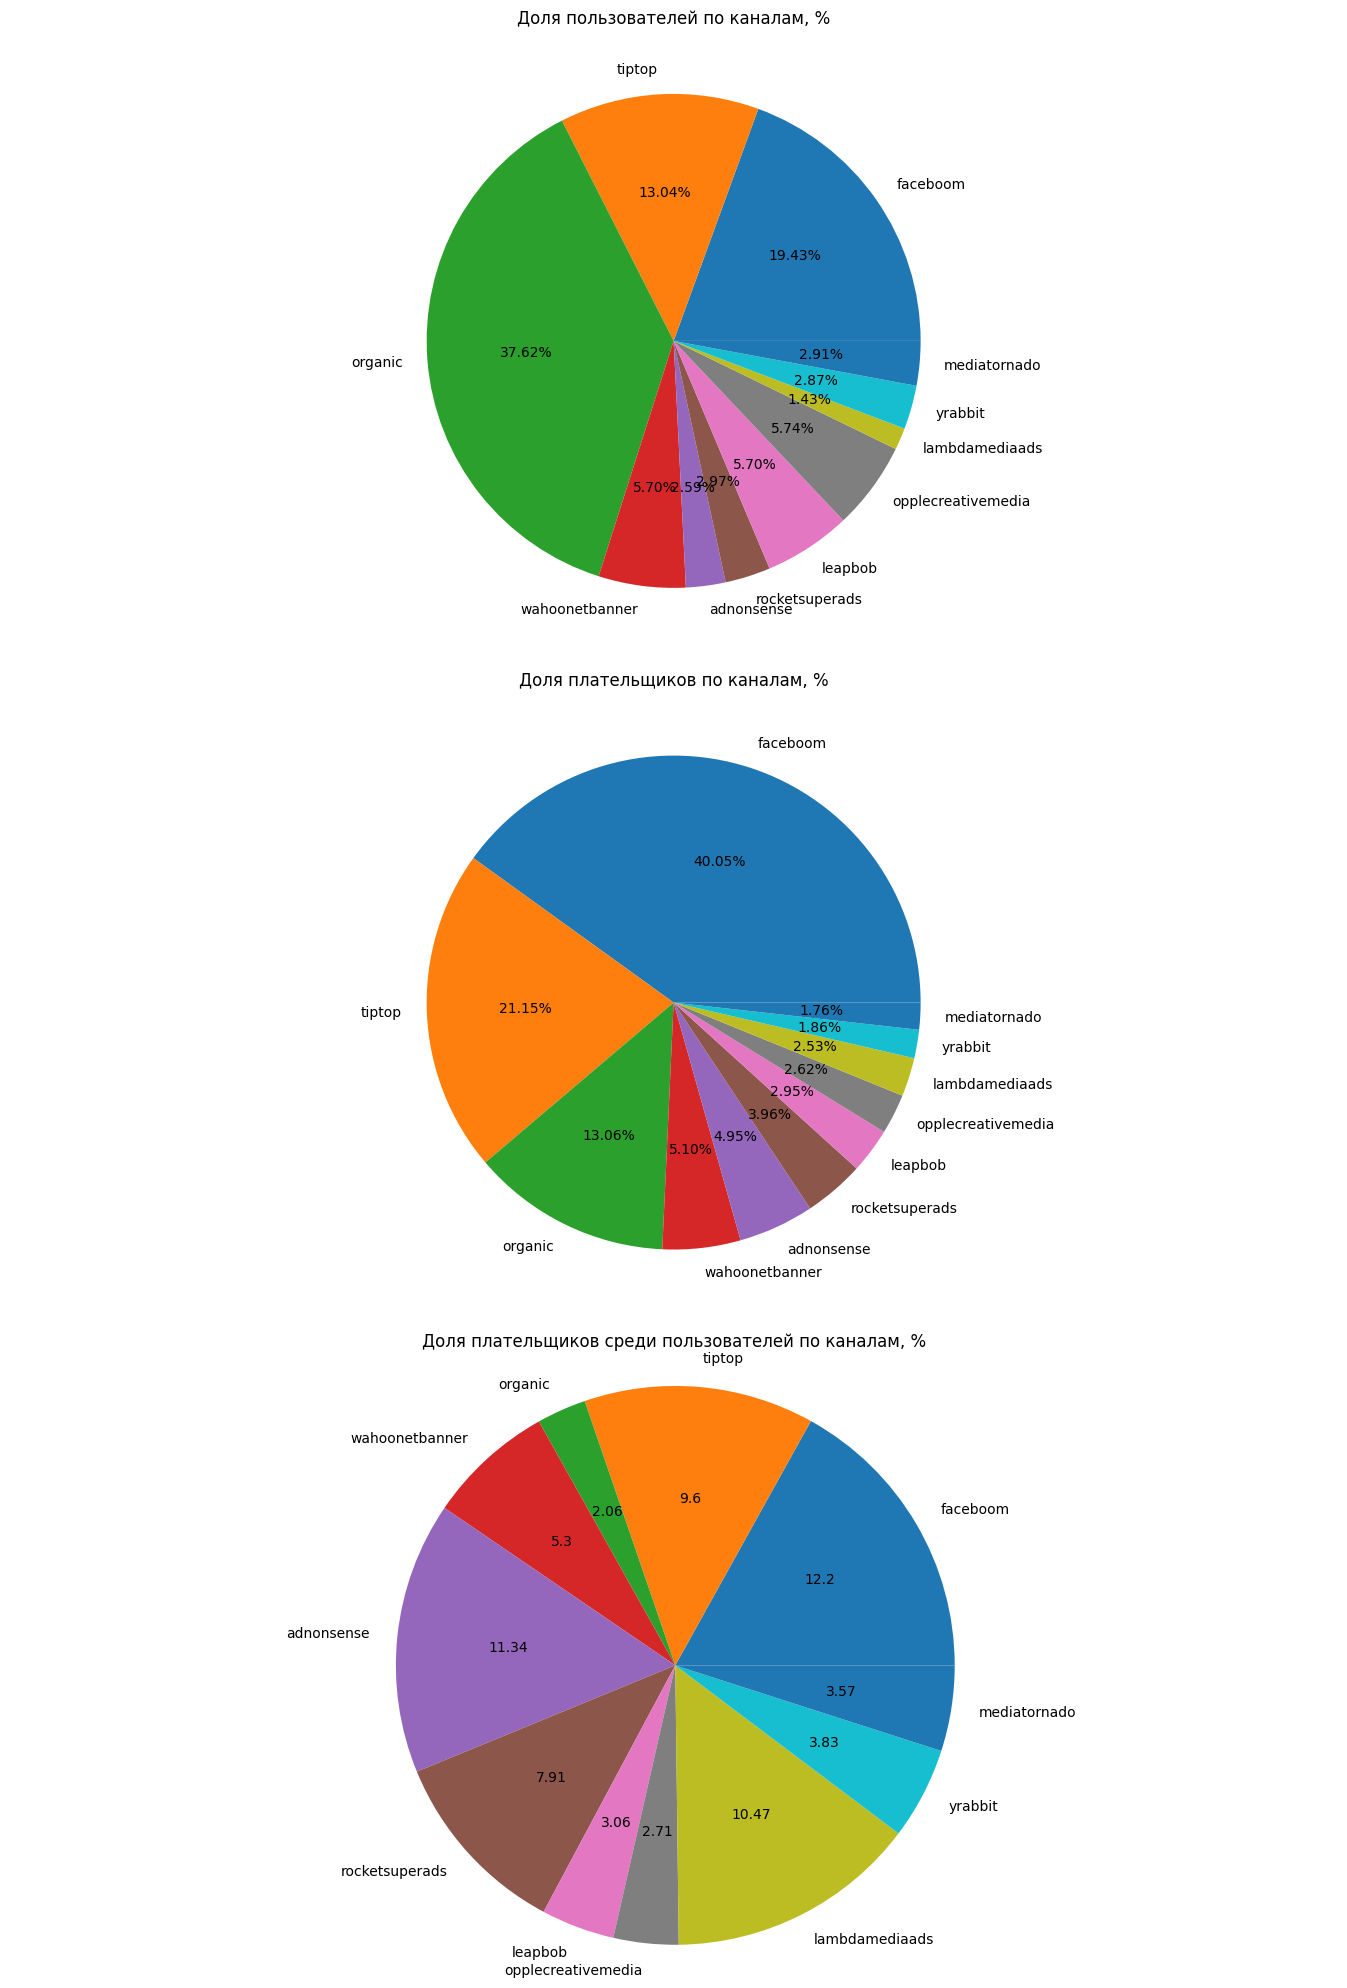

In [25]:
# сгрупируем данные по устройствам, посчитаем количество юзеров и плательщиков 
payer_channels = profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'}).reset_index()


# переименуем столбцы
payer_channels.columns = ['channel', 'quantity_users', 'quantity_payers']

# создадим столбцы с долей пользователей и плательщиков по устройствам

payer_channels['percent_users'] = round((payer_channels['quantity_users']/payer_channels['quantity_users'].sum()*100), 2)
payer_channels['percent_payers'] = round((payer_channels['quantity_payers']/payer_channels['quantity_payers'].sum()*100), 2)
payer_channels['percent_payers_in_users'] = round((payer_channels['quantity_payers']/payer_channels['quantity_users']*100), 2)

# отсортируем страны по уменьщению доли плательщиков
payer_channels = payer_channels.sort_values(by='percent_payers', ascending=False)

# Напечатаем таблицу c данными
display(payer_channels)

# построим график с двумя круговыми диаграммами 
fig, ax = plt.subplots(3, 1, figsize = (14, 20)) 

# увеличим расстояние между графиками
fig.tight_layout()

ax[0].pie(
    payer_channels['percent_users'], 
    labels=payer_channels['channel'], 
    autopct='%.2f%%'
)
ax[0].set_title('Доля пользователей по каналам, %')

ax[1].pie(
    payer_channels['percent_payers'], 
    labels=payer_channels['channel'], 
    autopct='%.2f%%'
)
ax[1].set_title('Доля плательщиков по каналам, %')


# создаем переменную для функции absolute_value (абсолютные значения для круговой диаграммы)
sizes = payer_channels['percent_payers_in_users']

ax[2].pie(
    payer_channels['percent_payers_in_users'], 
    labels=payer_channels['channel'],
# применяем созданную функцию absolute_value к параметру autopct
    autopct=absolute_value
)

ax[2].set_title('Доля плательщиков среди пользователей по каналам, %')
plt.axis('equal')

plt.show()

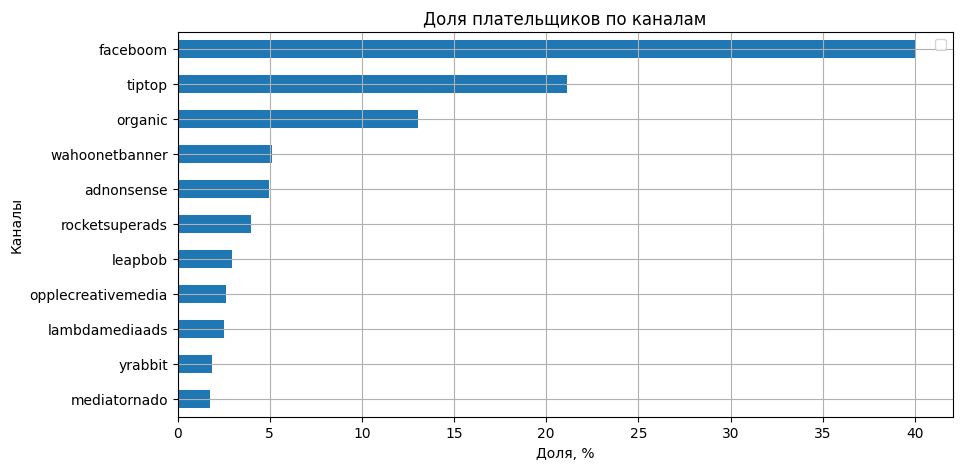

In [76]:
payer_channels.sort_values(by='percent_payers').plot.barh(x='channel', y='percent_payers', grid=True, figsize=(10, 5))
plt.title('Доля плательщиков по каналам')
plt.xlabel('Доля, %')
plt.ylabel('Каналы')
plt.legend('')
# Повернем годы на оси х под 45 градусов для удобства чтения
# plt.xticks(rotation = 45) 
plt.show()

Диаграммы с перечислением всех каналов слишком большие и трудно воспринимать, поэтому выделим в каждой диаграмме ТОП-5 каналов.

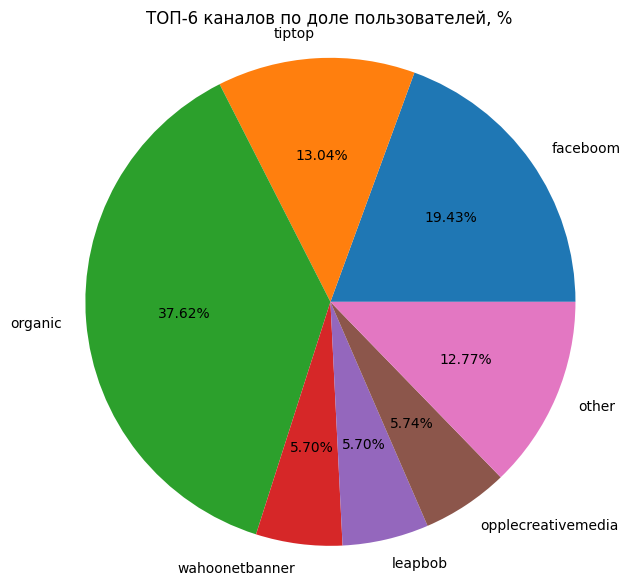

In [26]:
# сохраним в переменную платформы и их долю рынка 
top_percent_users = payer_channels[['channel','percent_users']]

# считаем сумму каналов не входящтих в топ-5
ratio_other_percent_users = top_percent_users.loc[top_percent_users['percent_users'] < 5.70]['percent_users'].sum()

# добавим в датафрейм строку с платформой oter и суммой процентов 
top_percent_users.loc[len(top_percent_users.index )] = ['other', ratio_other_percent_users]

# удалим из датафрейма платформы с низкой долей 
top_percent_users = top_percent_users.loc[top_percent_users['percent_users'] >= 5.70]

# строим диаграмму
top_percent_users.plot(y='percent_users', label='', labels=top_percent_users['channel'], kind='pie', legend=False, autopct='%.2f%%', figsize=(7, 7))

# задаем заголовок и печатаем диаграмму
plt.title("ТОП-6 каналов по доле пользователей, %")
# Включить равное масштабирование осей для круговой диаграммы
plt.axis('equal')
plt.show()

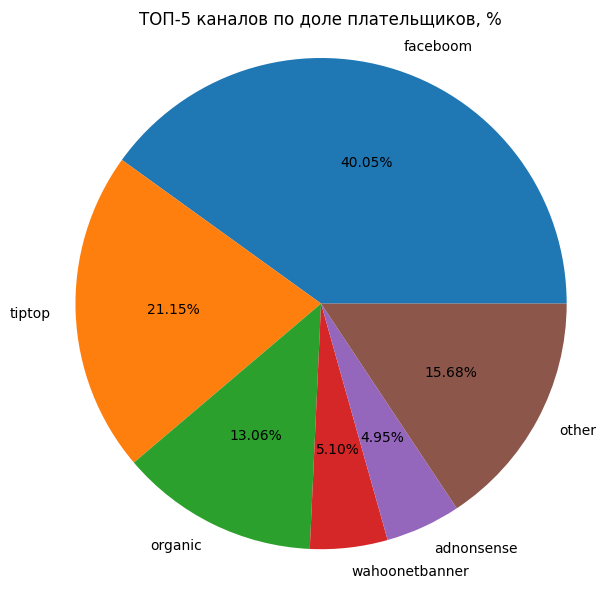

In [27]:
# сохраним в переменную платформы и их долю рынка 
top_percent_payers = payer_channels[['channel','percent_payers']]

# считаем сумму каналов не входящтих в топ-5
ratio_other_percent_payers = top_percent_payers.loc[top_percent_payers['percent_payers'] < 4.95]['percent_payers'].sum()

# добавим в датафрейм строку с платформой oter и суммой процентов 
top_percent_payers.loc[len(top_percent_payers.index )] = ['other', ratio_other_percent_payers]

# удалим из датафрейма платформы с низкой долей 
top_percent_payers = top_percent_payers.loc[top_percent_payers['percent_payers'] >= 4.95]

# строим диаграмму
top_percent_payers.plot(y='percent_payers', label='', labels=top_percent_payers['channel'], kind='pie', legend=False, autopct='%.2f%%', figsize=(7, 7))

# задаем заголовок и печатаем диаграмму
plt.title("ТОП-5 каналов по доле плательщиков, %")
# Включить равное масштабирование осей для круговой диаграммы
plt.axis('equal')
plt.show()

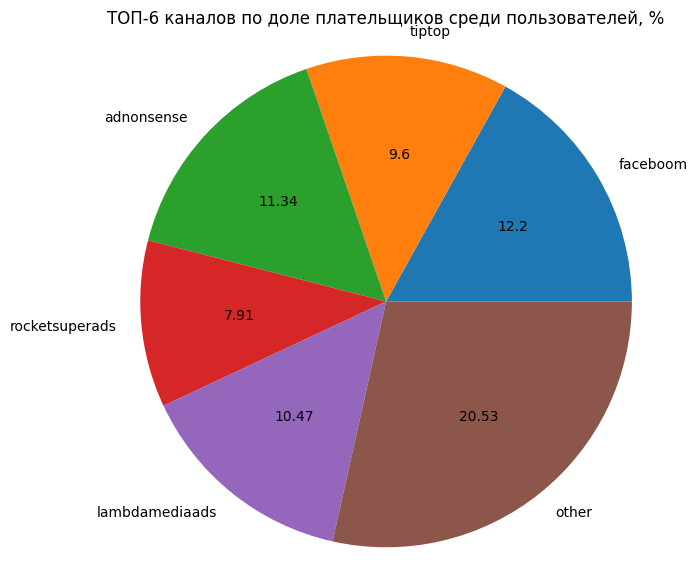

In [28]:
# сохраним в переменную платформы и их долю рынка 
top_percent_payers_in_users = payer_channels[['channel','percent_payers_in_users']]

# считаем сумму каналов не входящтих в топ-5
ratio_other_percent_users = top_percent_payers_in_users.loc[top_percent_payers_in_users['percent_payers_in_users'] < 7.91]['percent_payers_in_users'].sum()

# добавим в датафрейм строку с платформой oter и суммой процентов 
top_percent_payers_in_users.loc[len(top_percent_payers_in_users.index )] = ['other', ratio_other_percent_users]

# удалим из датафрейма платформы с низкой долей 
top_percent_payers_in_users = top_percent_payers_in_users.loc[top_percent_payers_in_users['percent_payers_in_users'] >= 7.91]

# строим диаграмму
top_percent_payers_in_users.plot(y='percent_payers_in_users', label='', labels=top_percent_payers_in_users['channel'], kind='pie', legend=False, autopct=absolute_value, figsize=(7, 7))

# создаем переменную для функции absolute_value (абсолютные значения для круговой диаграммы)
sizes = payer_channels['percent_payers_in_users']

# задаем заголовок и печатаем диаграмму
plt.title("ТОП-6 каналов по доле плательщиков среди пользователей, %")
# Включить равное масштабирование осей для круговой диаграммы
plt.axis('equal')
plt.show()

###### Вывод
Наиболее массовые каналы привлечения пользователей organic (37.62%), faceboom(19.43%), tiptop(13.04%). 
При этом больше всего платящих пользователей пришло из следующих 5 каналов:
1. faceboom - 40.05%
2. tiptop - 13.04%
3. organic - 37.62%
4. wahoonetbanner - 5.70%

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Расходы по каналам

In [29]:
# считаем общие ирасходы на макетинг

print('Общая сумма расходов на маркетинг:', round(profiles['acquisition_cost'].sum()))
profiles.head(5)

Общая сумма расходов на маркетинг: 105498


user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    faceboom     mac  united states   
1   4919697 2019-07-09 12:46:07    faceboom  iphone  united states   
2   6085896 2019-10-01 09:58:33     organic  iphone         france   
3  22593348 2019-08-22 21:35:48  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:44     yrabbit  iphone  united states   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [30]:
# Выясним сколько денег потратили на каждый рекламный источник
costs_by_source = profiles.groupby('channel').agg({'acquisition_cost':'sum'}).reset_index()
costs_by_source.columns = ['channel','sum_cost']
costs_by_source.sort_values(by='sum_cost', ascending=False)

channel  sum_cost
8               tiptop   54751.3
1             faceboom   32445.6
9       wahoonetbanner    5151.0
0           adnonsense    3910.6
5   opplecreativemedia    2151.3
7       rocketsuperads    1834.2
3              leapbob    1798.0
2       lambdamediaads    1557.6
4         mediatornado     954.1
10             yrabbit     944.3
6              organic       0.0

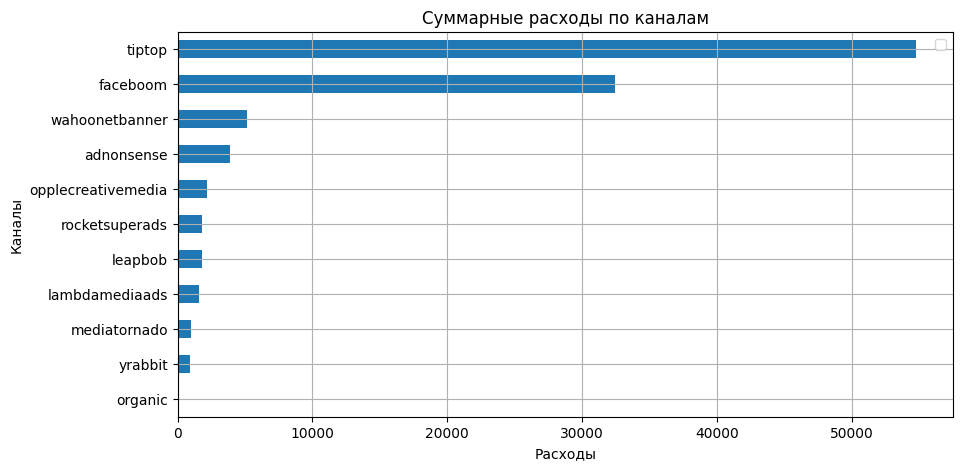

In [31]:
# построим график для наглядного отображения суммарных расходов по каналам
costs_by_source.sort_values(by='sum_cost').plot.barh(x='channel', y='sum_cost', grid=True, figsize=(10, 5))
plt.title('Суммарные расходы по каналам')
plt.xlabel('Расходы')
plt.ylabel('Каналы')
plt.legend('')
# Повернем годы на оси х под 45 градусов для удобства чтения
#plt.xticks(rotation = 45) 
plt.show()

###### Вывод
Общая сумма расходов на маркетинг: 105 498 долларов. Больше всего денег на рекламу было потрачено в tiptop (54 751,3 долл, больше половины суммарных расходов) и faceboom (32 445,6 долл.).

Учитывая, что faceboom приносит 19.43% пользователей и 40.05% всех плательщиков, а tiptop - 13.04% пользователей и 13.04% плательщиков, расходы на tiptop кажутся неоправданными.

Расходы на остальные каналы в диапазоне от 5151 до 944 долларов.

Самые дешевые каналы: mediatornado	(954.1 долл) и yrabbit (944.3 долл). Источник organic - бесплатный, на него расходов не было.

#### Динамика изменения расходов по источникам
Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.

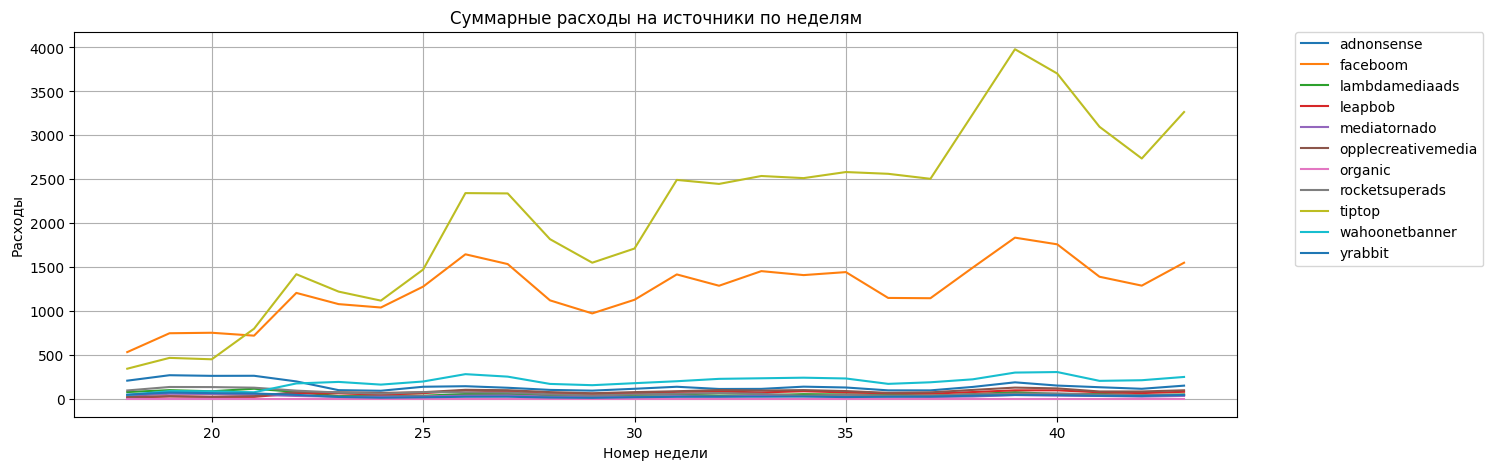

In [32]:
expenses_over_time = profiles
expenses_over_time['dt'] = pd.to_datetime(expenses_over_time['dt']) # приводим данные к формату datetime
expenses_over_time['week'] = expenses_over_time['dt'].dt.isocalendar().week # вычисляем номера недель

# Строим график динамики изменения расходов по неделям для каждого источника
expenses_over_time.pivot_table(
    index='week',  # группируем по неделям
    columns='channel',  # источники переходов
    values='acquisition_cost',  # стоимость привлечения 
    aggfunc='sum'  # подсчёт суммы расходов на источник
).plot(figsize=(15, 5), grid=True)
plt.title('Суммарные расходы на источники по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad= 0)
plt.show()

Два лидера tiptop, faceboom мешают рассмотреть график прочих каналов. Построем график исключив два лидера.

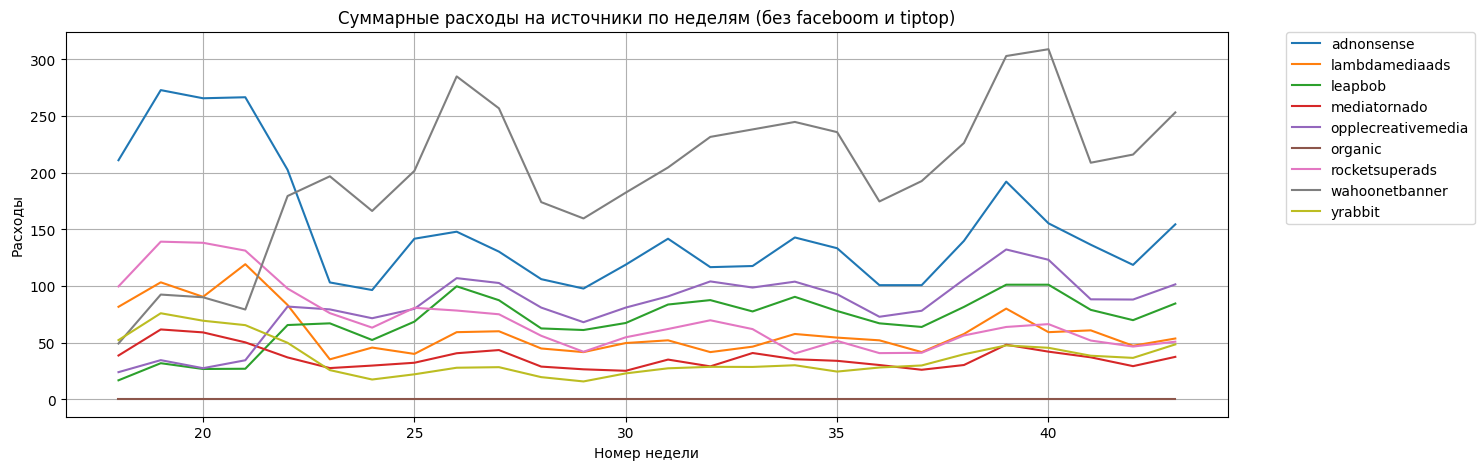

In [33]:
expenses_over_time.query('channel != ["tiptop", "faceboom"]').pivot_table(
    index='week',  # группируем по неделям
    columns='channel',  # источники переходов
    values='acquisition_cost',  # стоимость привлечения 
    aggfunc='sum'  # подсчёт суммы расходов на источник
).plot(figsize=(15, 5), grid=True)
plt.title('Суммарные расходы на источники по неделям (без faceboom и tiptop)')
plt.xlabel('Номер недели')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad= 0)
plt.show()

In [34]:
print('Количество недель в исследуемом датафрейме:', profiles['week'].nunique())
print('Самая ранняя неделя в исследуемом датафрейме:', profiles['week'].min())
print('Самая поздняя неделя в исследуемом датафрейме:', profiles['week'].max())

Количество недель в исследуемом датафрейме: 26
Самая ранняя неделя в исследуемом датафрейме: 18
Самая поздняя неделя в исследуемом датафрейме: 43


In [35]:
# узнаем сколько всего дененег по каналам потрачено по неделям
expenses_over_time.groupby('week').agg({'acquisition_cost': ['sum', 'mean']})

acquisition_cost          
                  sum      mean
week                           
18             1455.5  0.323373
19             2031.6  0.318832
20             1976.3  0.319015
21             2297.6  0.385827
22             3426.9  0.578966
23             2915.5  0.610448
24             2706.1  0.628595
25             3421.3  0.642015
26             4836.8  0.702819
27             4660.5  0.719991
28             3516.7  0.733869
29             3039.9  0.731801
30             3445.8  0.708575
31             4609.6  0.778517
32             4446.9  0.764729
33             4703.9  0.784114
34             4670.4  0.762763
35             4732.3  0.791752
36             4280.7  0.849682
37             4228.0  0.858303
38             5474.0  0.852382
39             6784.3  0.856604
40             6365.5  0.848620
41             5190.4  0.880475
42             4680.2  0.852806
43             5601.3  0.866136

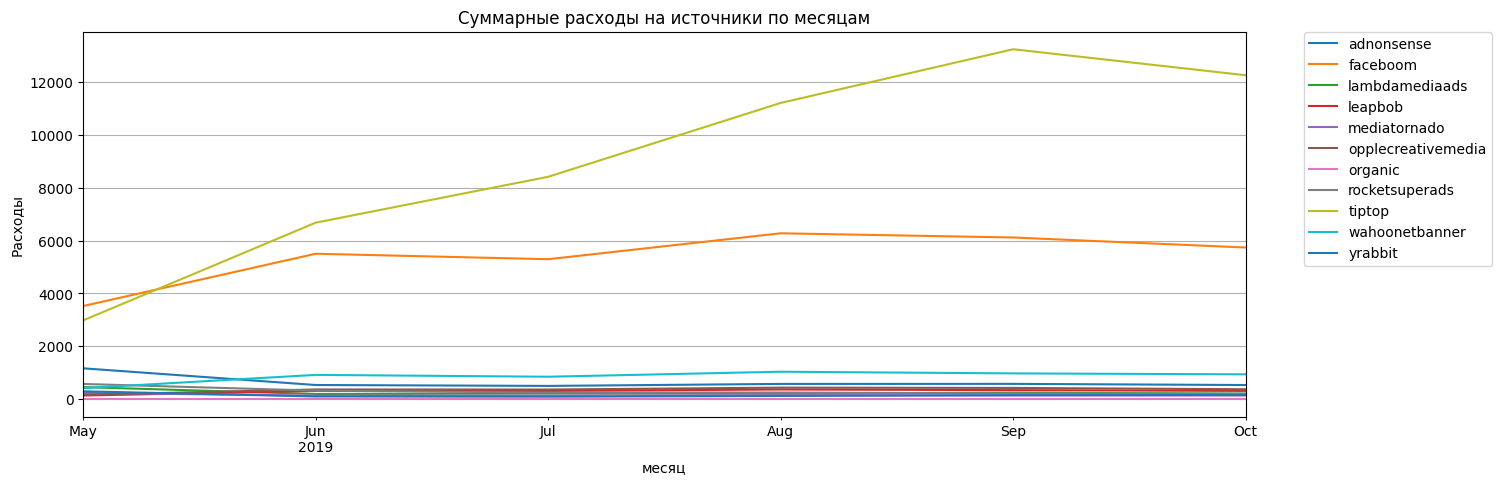

In [36]:
# Строим график динамики изменения расходов по месяцам для каждого источника
expenses_over_time.pivot_table(
    index='month',  # группируем по месяцам
    columns='channel',  # источники переходов
    values='acquisition_cost',  # стоимость привлечения 
    aggfunc='sum'  # подсчёт суммы расходов на источник
).plot(figsize=(15, 5), grid=True)
plt.title('Суммарные расходы на источники по месяцам')
plt.xlabel('месяц')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad= 0)
plt.show()

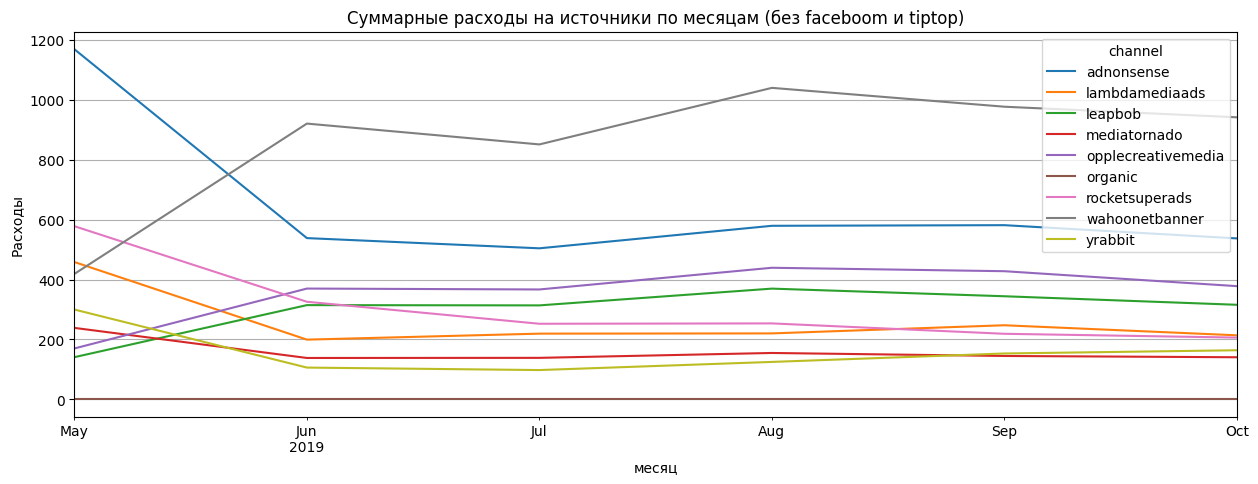

In [37]:
# Строим график динамики изменения расходов по месяцам для каждого источника
expenses_over_time.query('channel != ["tiptop", "faceboom"]').pivot_table(
    index='month',  # группируем по месяцам
    columns='channel',  # источники переходов
    values='acquisition_cost',  # стоимость привлечения 
    aggfunc='sum'  # подсчёт суммы расходов на источник
).plot(figsize=(15, 5), grid=True)
plt.title('Суммарные расходы на источники по месяцам (без faceboom и tiptop)')
plt.xlabel('месяц')
plt.ylabel('Расходы')
plt.show()

In [38]:
print('Количество месяцев в исследуемом датафрейме:', profiles['month'].nunique())
print('Самая ранняя неделя в исследуемом датафрейме:', profiles['month'].min())
print('Самая поздняя неделя в исследуемом датафрейме:', profiles['month'].max())

Количество месяцев в исследуемом датафрейме: 6
Самая ранняя неделя в исследуемом датафрейме: 2019-05-01 00:00:00
Самая поздняя неделя в исследуемом датафрейме: 2019-10-01 00:00:00


In [39]:
# узнаем сколько всего дененег по каналам потрачено по месяцам
expenses_over_time.groupby('month').agg({'acquisition_cost': ['sum', 'mean']})

acquisition_cost          
                        sum      mean
month                                
2019-05-01           9978.6  0.368065
2019-06-01          15089.0  0.652554
2019-07-01          16447.8  0.726910
2019-08-01          20657.9  0.777022
2019-09-01          22441.7  0.852421
2019-10-01          20883.0  0.861723

###### Вывод
Недельный график показывает, что на протяжении всего исследуемого периода с 18 по 43 неделю расходы на каналы tiptop и faceboom значительно превышают траты на прочие рекламные каналы. 

С 18 по 21 неделю расходы на faceboom составляли 500-700 долл и превышали расходы на tiptop. Однако далее траты на tiptop стали превышать faceboom. На пике (примерно на 39 неделе) расходы tiptop составили 4000 дол, в это же время траты на faceboom составили около 1700 долл.

Другие источники на протяжении всех 26 недель имеют сильные колебания расходов, но не превышают 300 долл в неделю.

Месячный график подтверждает описанные выше выводы. Добавим, что расходы faceboom в сентябре 2019 года вышли на плато около 5800-6000 дол и деоржится на этом уровне до октября.
Рост расходов tiptop начался в мае примерно с 3000 дол и продолжился до сентября 2019, достигнув пика. В октябре случилось не большое снижение.

У прочих каналов за исключением wahoonetbanner в помесячной разбивке самые большие расходы были в мае 2019 года,  видим снижение расходов в июне снизизлись и сохранились до октября 2019 года.

#### Средняя стоимость привлечения
Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [40]:
cac_mean = profiles.groupby('channel').agg({'acquisition_cost': 'mean'})\
        .sort_values(by='acquisition_cost', ascending=False).reset_index()

cac_mean.columns=['channel','cac_mean']
cac_mean

channel  cac_mean
0               tiptop  2.799003
1             faceboom  1.113286
2           adnonsense  1.007887
3       lambdamediaads  0.724802
4       wahoonetbanner  0.602245
5       rocketsuperads  0.412365
6   opplecreativemedia  0.250006
7              yrabbit  0.218994
8         mediatornado  0.218630
9              leapbob  0.210219
10             organic  0.000000

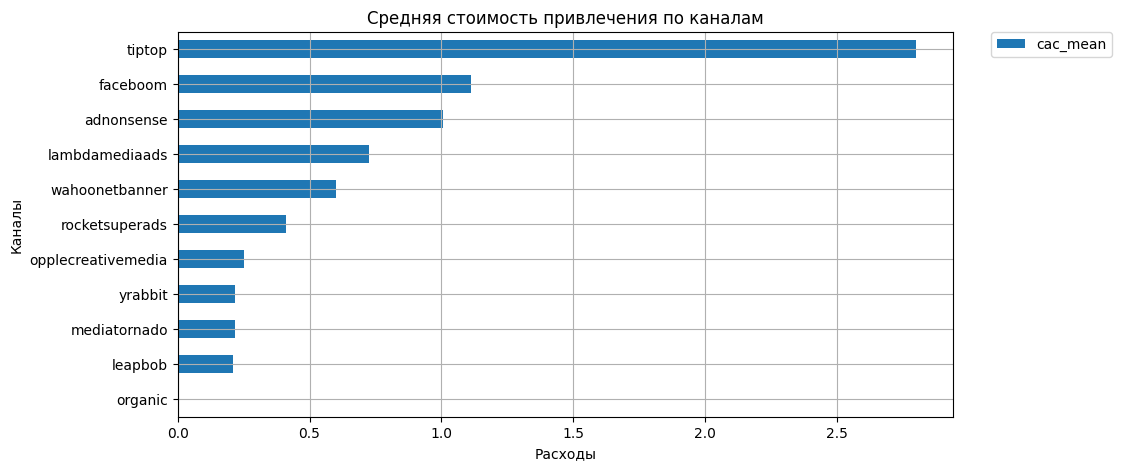

In [41]:
cac_mean.sort_values(by='cac_mean').plot.barh(x='channel', y='cac_mean', grid=True, figsize=(10, 5))
plt.title('Средняя стоимость привлечения по каналам')
plt.xlabel('Расходы')
plt.ylabel('Каналы')
plt.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad= 0)
plt.show()

###### Вывод
Наиболее высокая средняя стоимость привлечения у tiptop - 2.8 долл за пользователя. Это в 2,5 раза выше чем у другого лидера - faceboom	(1.11 долл за пользователя). Канал adnonsense привелекает одного пользователя в среднем за 1 доллар.

В остальных каналах пользователя стоит меньше 1 доллара. Самый дешевый среди них leapbob (0.2 долл). Канал organic бесплатный.

### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Анализ LTV, CAC и ROI в целом

Удалим из исследуемых данных органических пользователей. На их привлечение не были затрачены деньги, поэтому они могут повлиять на выводы исследования. Установим момент и горизонт анализа данных.

In [42]:
edited_profiles = profiles.query('channel != "organic"')

# момент анализа - 1 ноября 2019г 
observation_date = datetime(2019, 11, 1).date()  

# горизонт анализа 14 дней, т.к.пользователи должны окупаться не позднее чем через две недели после привлечения 
horizon_days = 14  

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

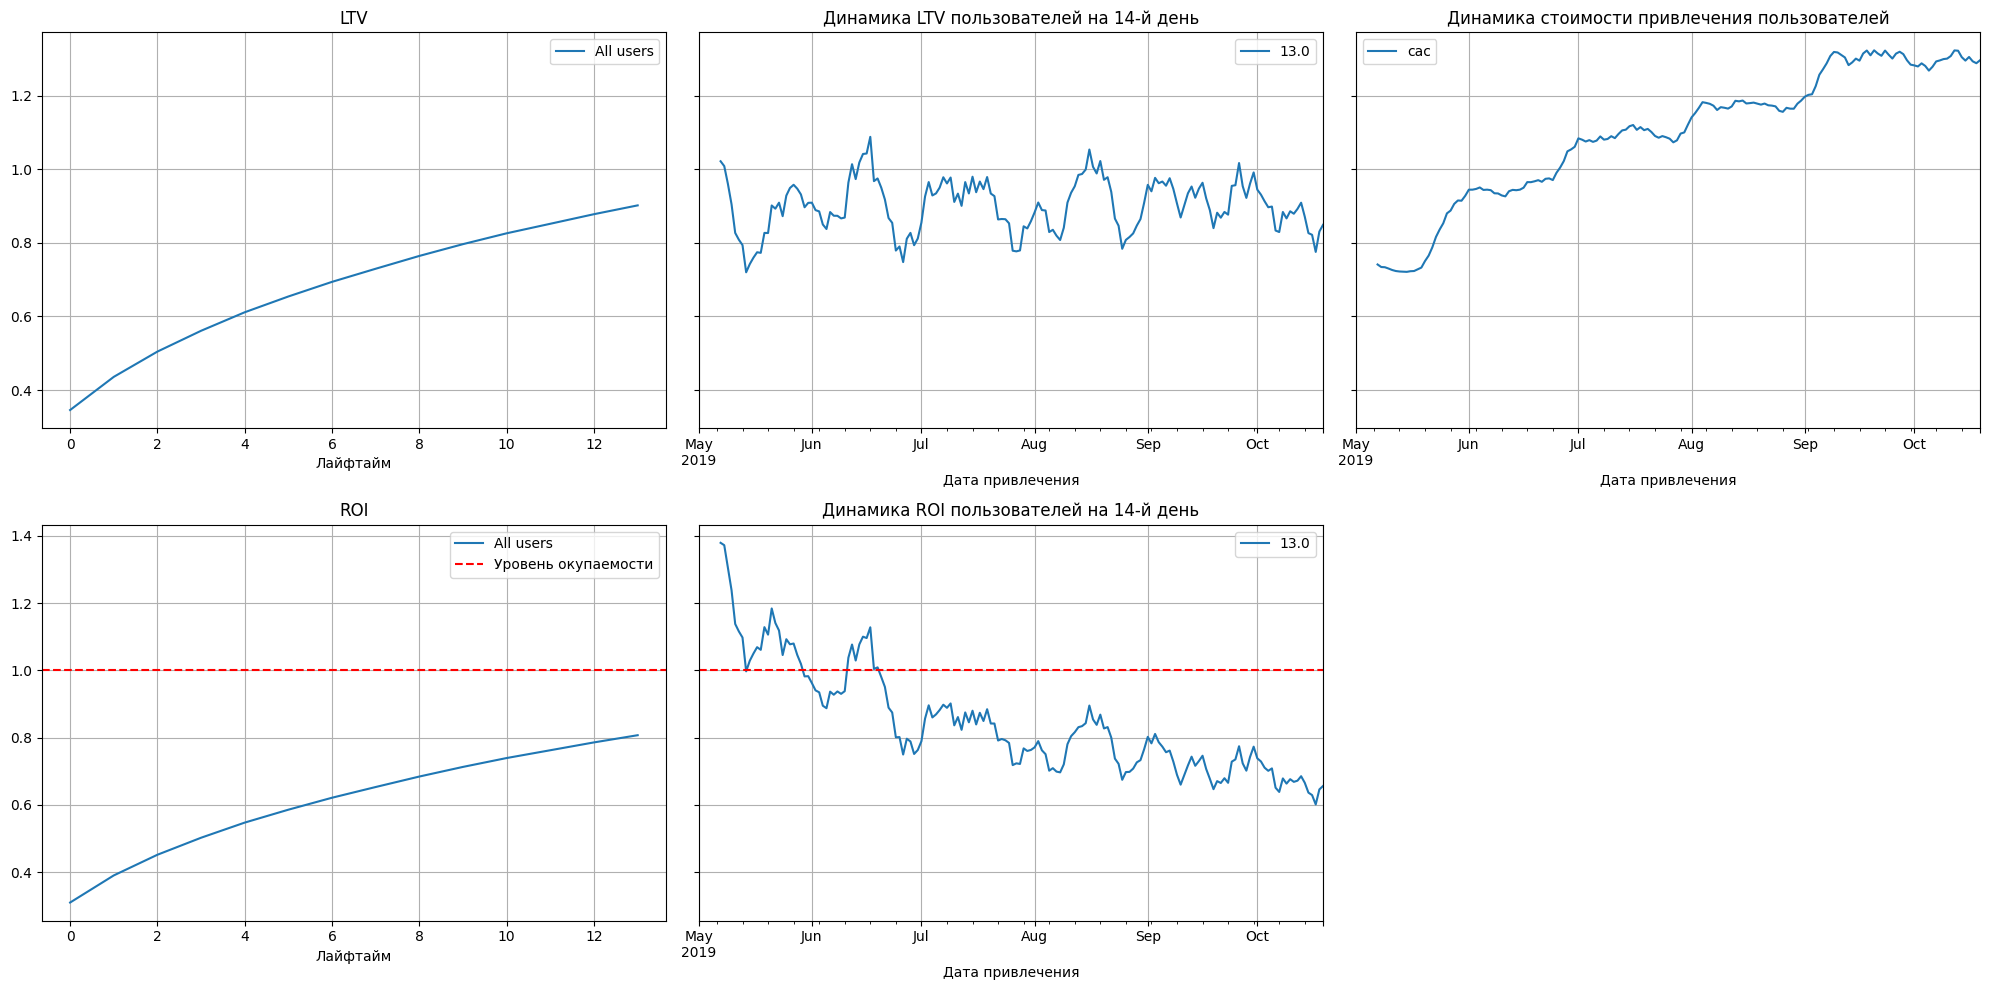

In [43]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

###### Вывод
По графикам можно сделать такие выводы:
* Реклама, направленная на привлечение пользователей, в целом не окупается. ROI к концу второй недели — чуть выше 80%. С июня 2019 года видим стабильное падение ROI. Скорее всего это связано с увеличением стоимости привлечения одного клиента (CAC). 
* САС растет начиная с середины мая 2019 года. Каждый новый клиент с течением времени обходится компании все дороже, поэтому возврат инвестиций (ROI) снижается.  
* LTV достаточно стабилен, месяц от месяца этот показатель колеблется в диапазоне примерно от 0.8 до 1. Значит, дело не в ухудшении качества пользователей.

#### Конверсия и удержание в целом
Проверим конверсию и удержание пользователей и динамику их изменения. Построим и изучим графики конверсии и удержания.

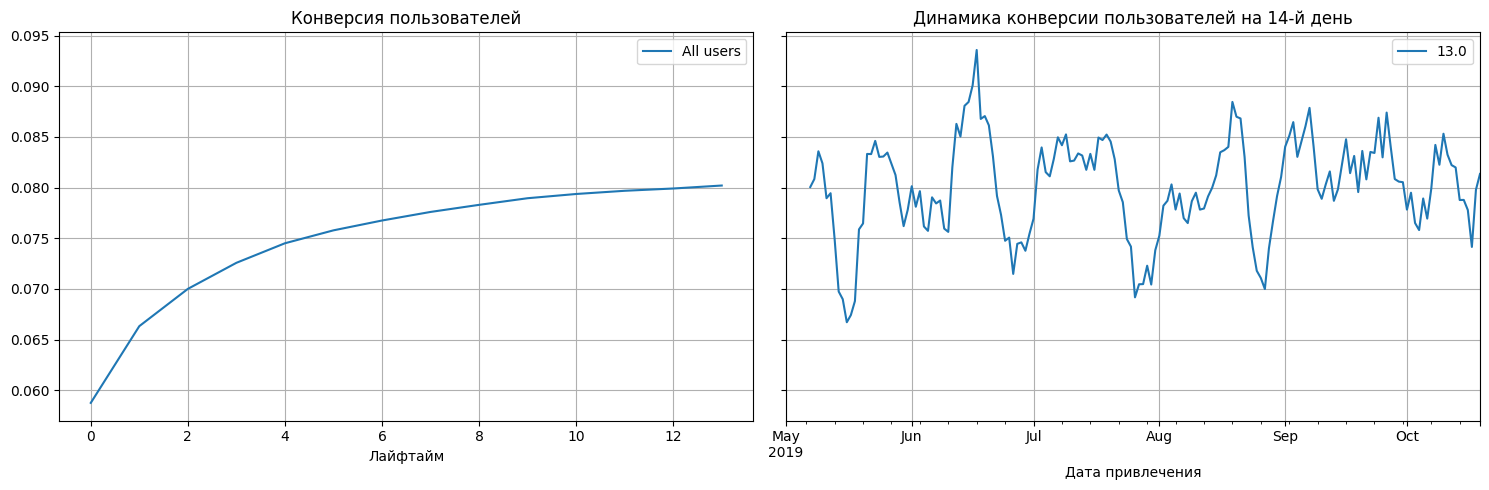

In [44]:
# исследуем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

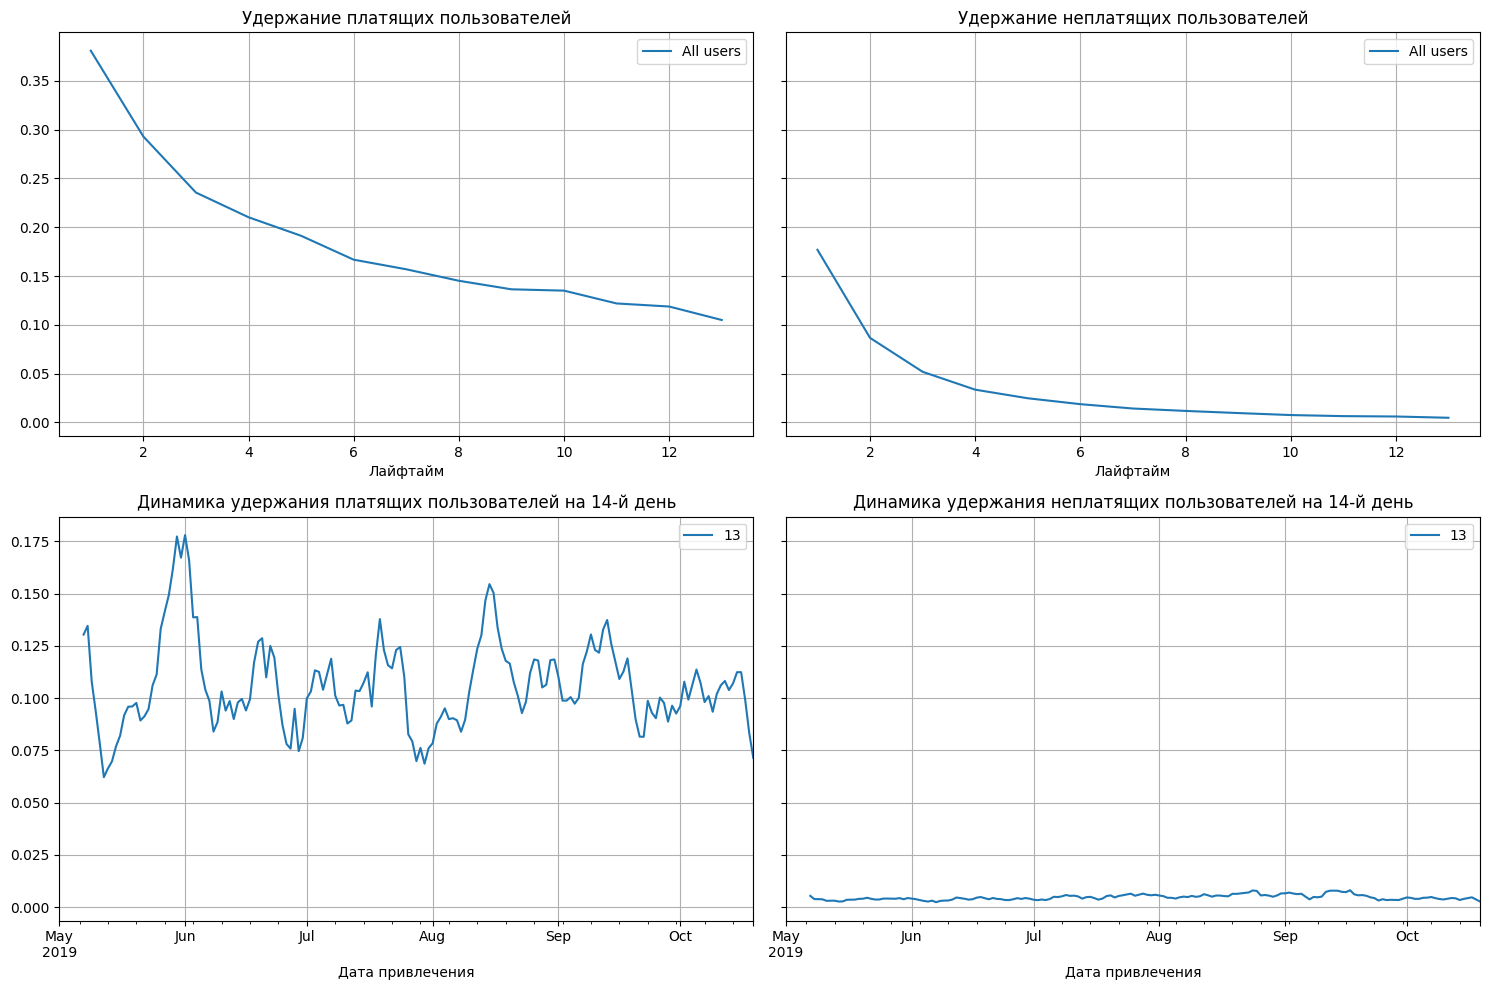

In [45]:
# исследуем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

###### Вывод
Кривая конверсии в норме, т.к. плавно растет от нуля в направлении единицы и не снижается. Самая высокая конверсия пользователей имеется в первые 2 лайфтайма (дня) -  примерно по 5% в день. В 3 и 4 лайфтайм прирост конверсии - около 2,5%. Далее конверсия замедляется, к 11 дню рост конверсии кривой уже незначительный. 

По динамике конверсии пользователей видны просадки значительные просадки в середине мая, конце июня, июля и августа - возможно это с сезонностью или особенностью рекламных кампаний.

Платящие пользователи удерживаются лучше неплатящих - график удержания платящих снижается более плавно, чем график удержания неплатящих. Динамика удержания платящих колеблется от 7 до 17%. Динамика неплатящих очень низкая - такие пользователи редко возвращаются в приложение.

#### Анализ окупаемости по устройствам
Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

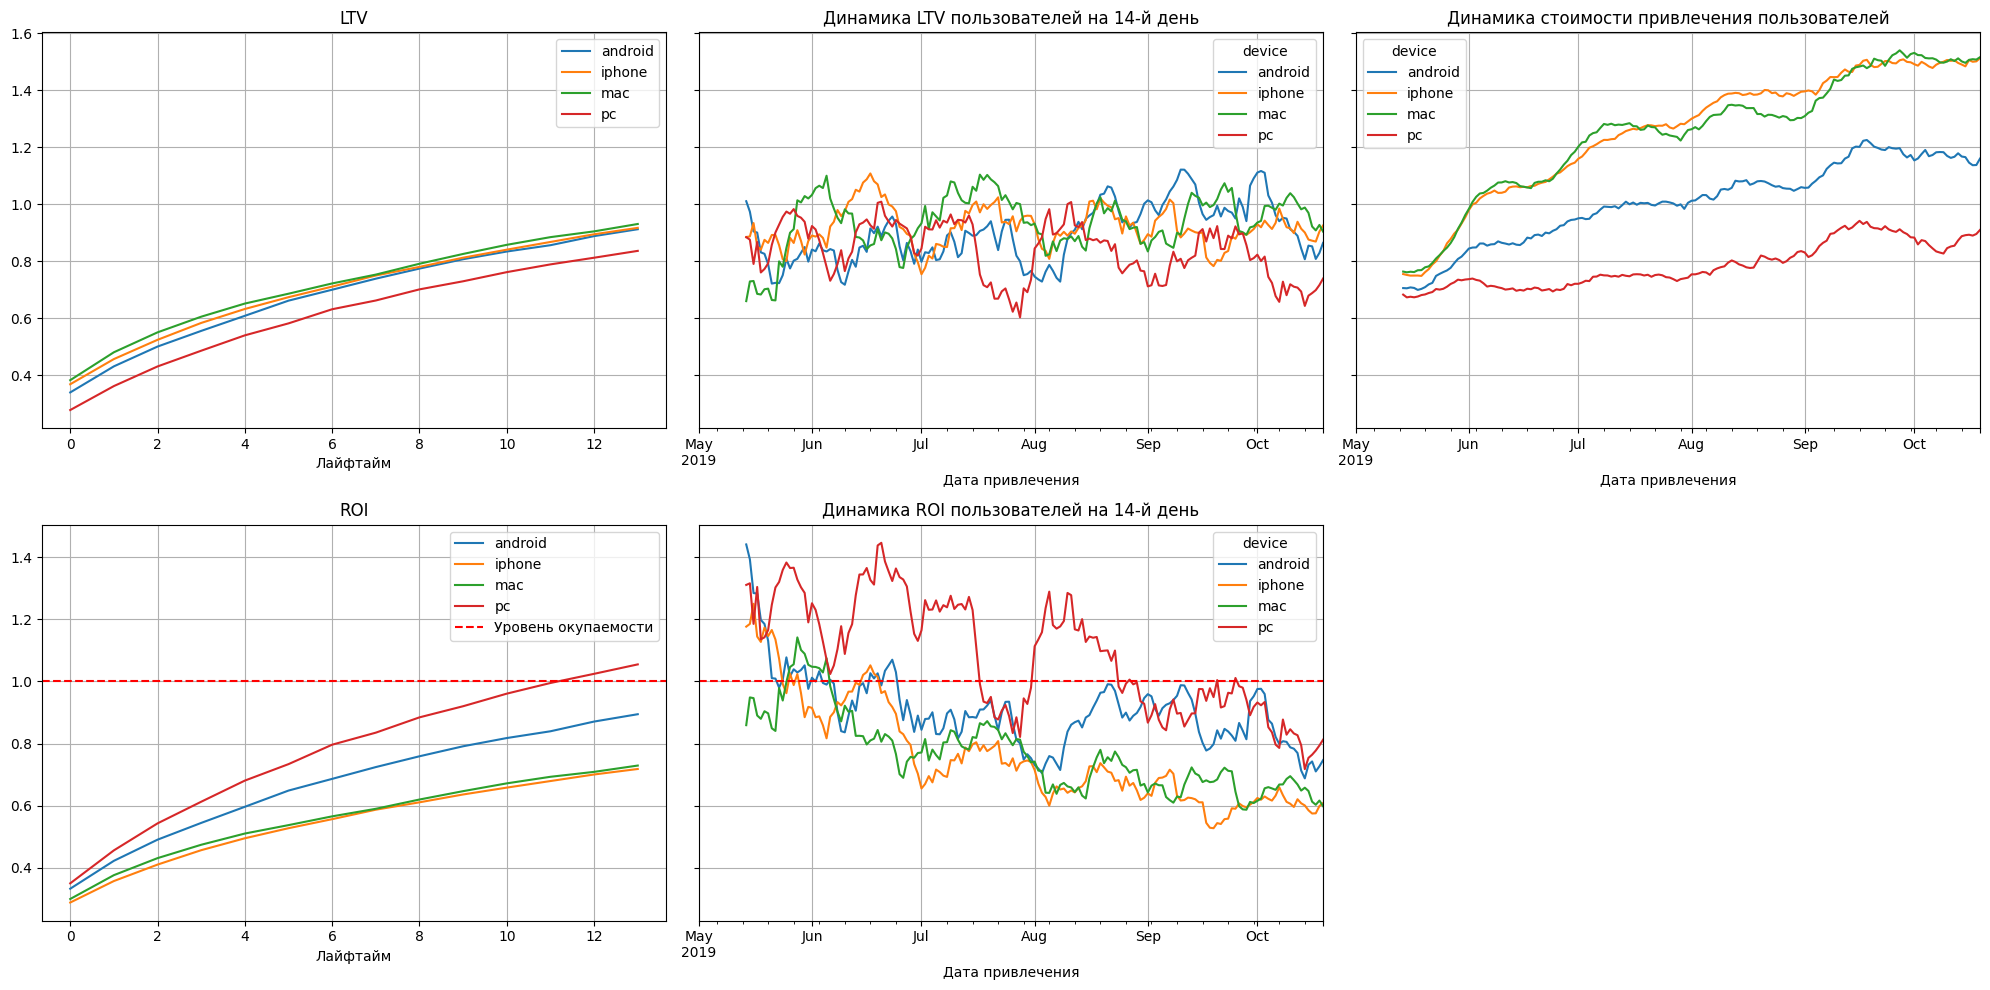

In [46]:
# задаем разбивку по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

###### Вывод
Среди всех видов устройств окупается только PC, пользователи этих устройств приносят больше, чем на них трятят. График ROI пользователей PC пересекает уровень окупаемости примерно на 11 день жизни пользователя, на 12-14 дни пользователь уже приносит прибыль. Скорее всего это связано с тем, что стоимость привлечения пользователей на РС с мая по октябрь 2019 года росла меньшими темпами, чем на других устройствах.
Однако и у РС-пользователей окупаемость начинает снижаться с сентября 2019г (на графике динамики ROI линия РС упаля ниже уровня окупаемости).

Пользователи устройств Android, Mac и iPhone не окупаются. Уровень окупаемости они превышали только в конце мая-начале июля, а также короткое время в середине июня. Далее стали убыточными. Неокупаемость устройств Android, Mac и iPhone также связана с интенсивным ростом расходов на привлечения пользователей, который начался в конце мая.    

###### Рекомендация - оптимизировать стоимость привлечения на устройствах  Android, Mac и iPhone.

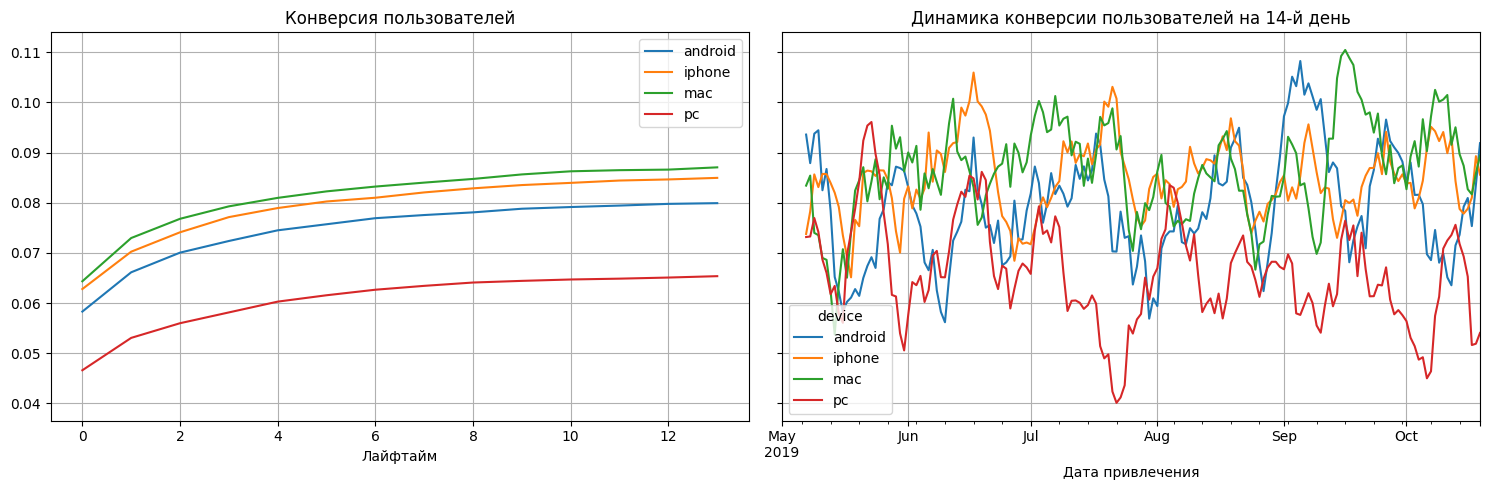

In [47]:
# исследуем конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

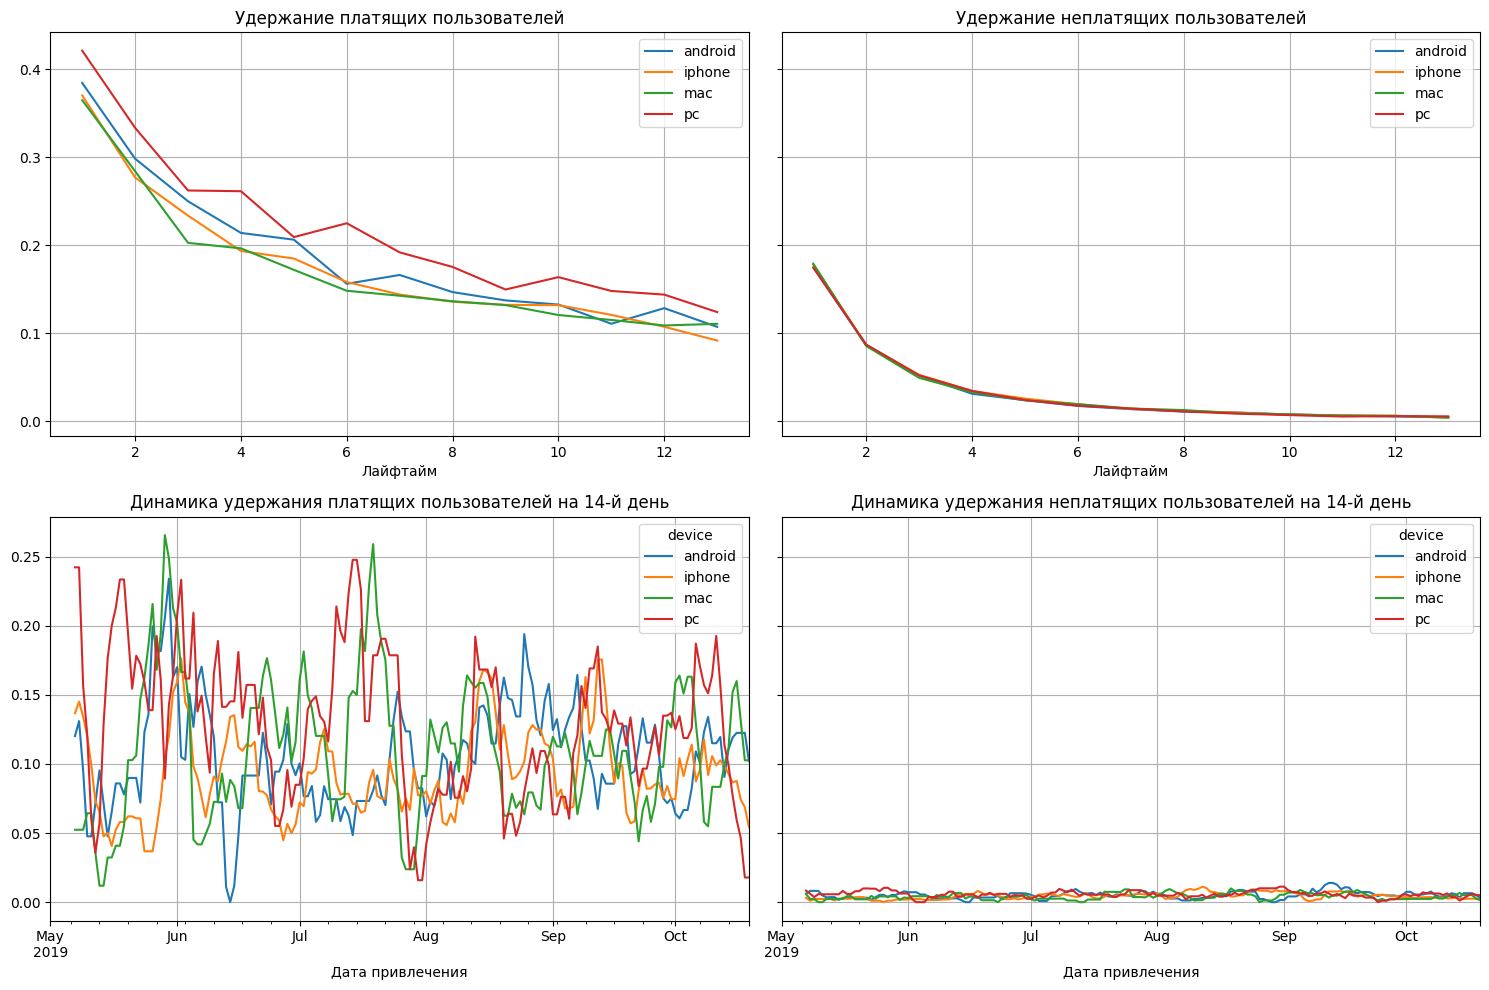

In [48]:
# удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

###### Вывод
Лидеры по конверсии - Mac, iPhone и Android. Они конвертируются лучше чем пользователи РС. Однако с точки зрения удержания платящих пользователей лидирует именно РС. Можно предположить, что устройства РС отличаются от мобильных платформ качеством/удобством взаимодействия (понятностью интерфейса) - поэтому пользователям проще возвращаться в приложение.  


#### Анализ окупаемости по cтранам
Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

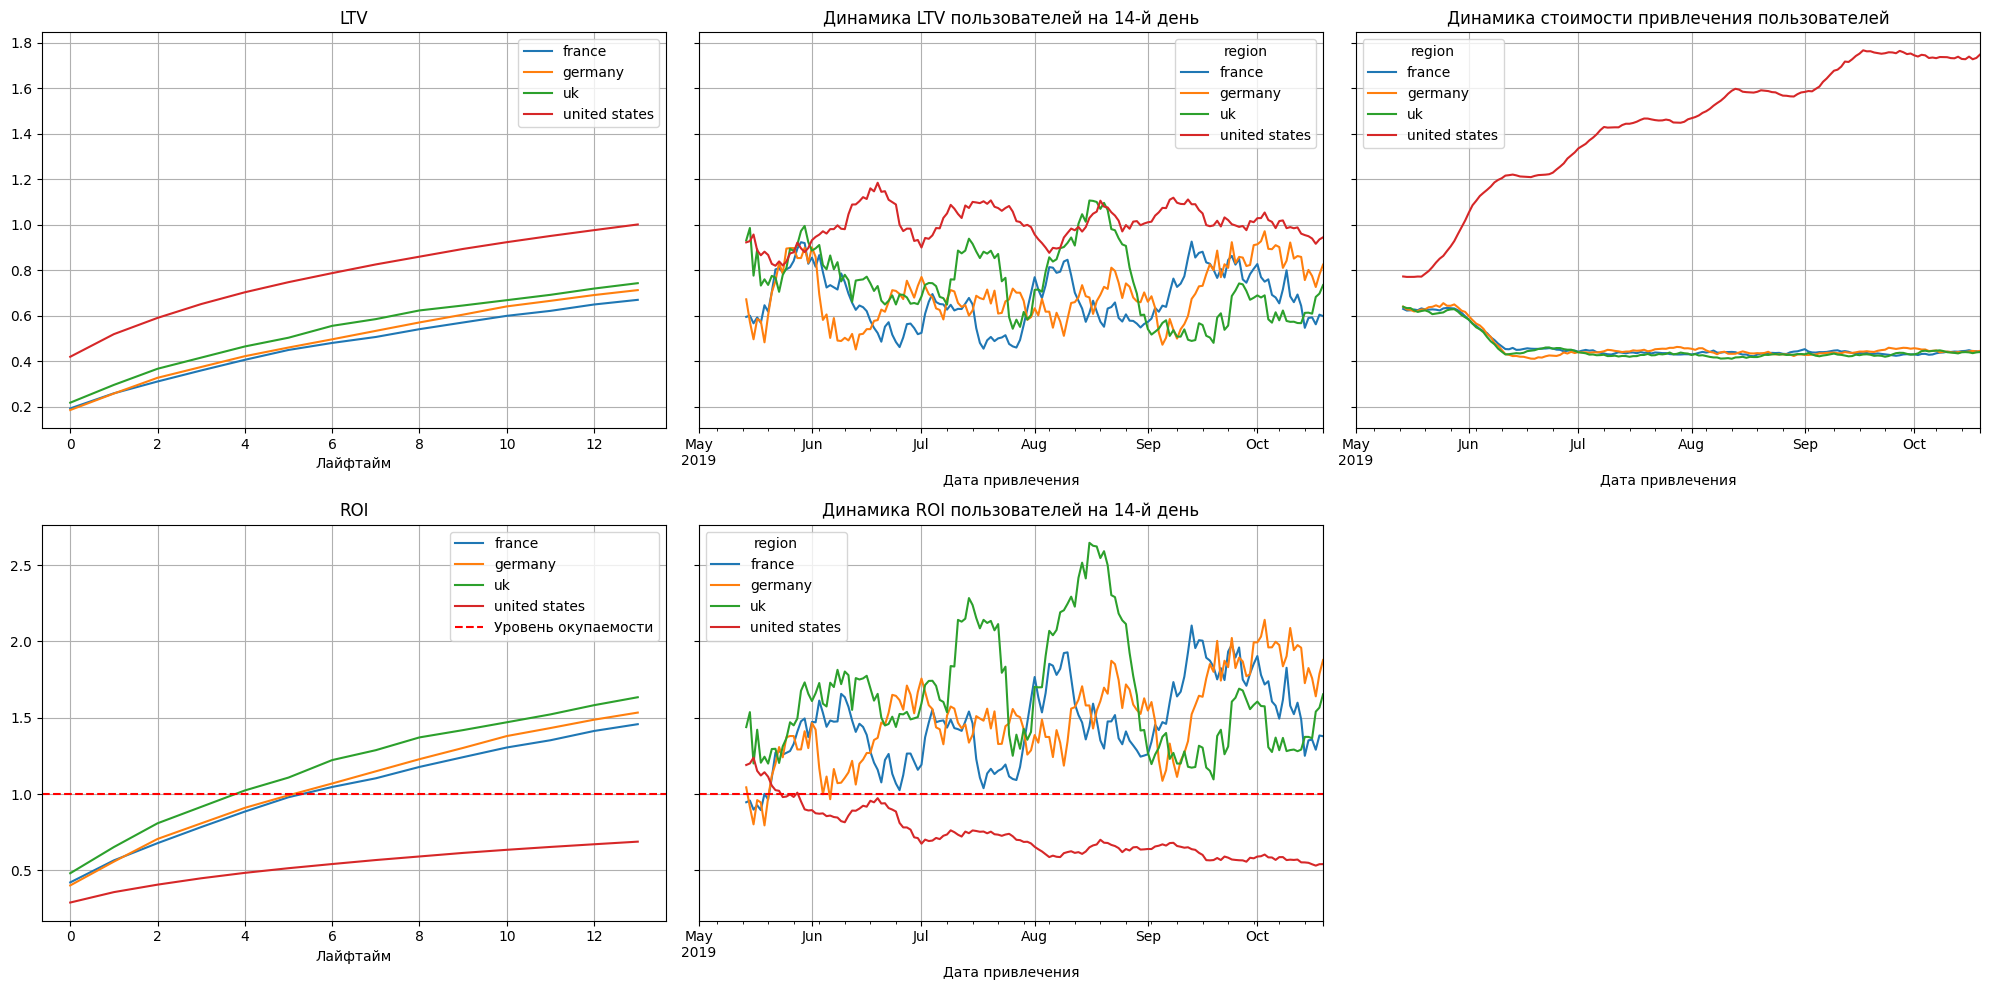

In [49]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

###### Вывод: 

Пользователи из Великобритании окупаются примерно на 4 день жизни в приложении, из Германии и Франции - примерно на 5 день. Пользователи из США не окупаются за 14 дней отведенных на это разработчиками приложения, даже не смотря на то, что LTV у них самая высоках среди всех стран.

Очевидно это связано с огромными расходами на привлечение пользователей в США - САС в этом регионе интенсивно рос с середины мая по октябрь 2019 года. Вспомним, что в США находятся 66,66% всех пользователей приложения и 77.72% всех плательщиков. Большие расходы на привлечение пользователей-американцев "съедают" всю прибыль от их "жизни" в приложении.

###### Основная рекомендация для разработчиков приложения - оптимизировать стоимость привлечения пользователей в США. 

Стоимость привлечения пользователей в Великобритании, Германии и Франции наоборот снижалась с середины мая до середины июня 2019 года и далее была стабильна до октября. Это способствовало оокупаемости пользователей их данных стран. 

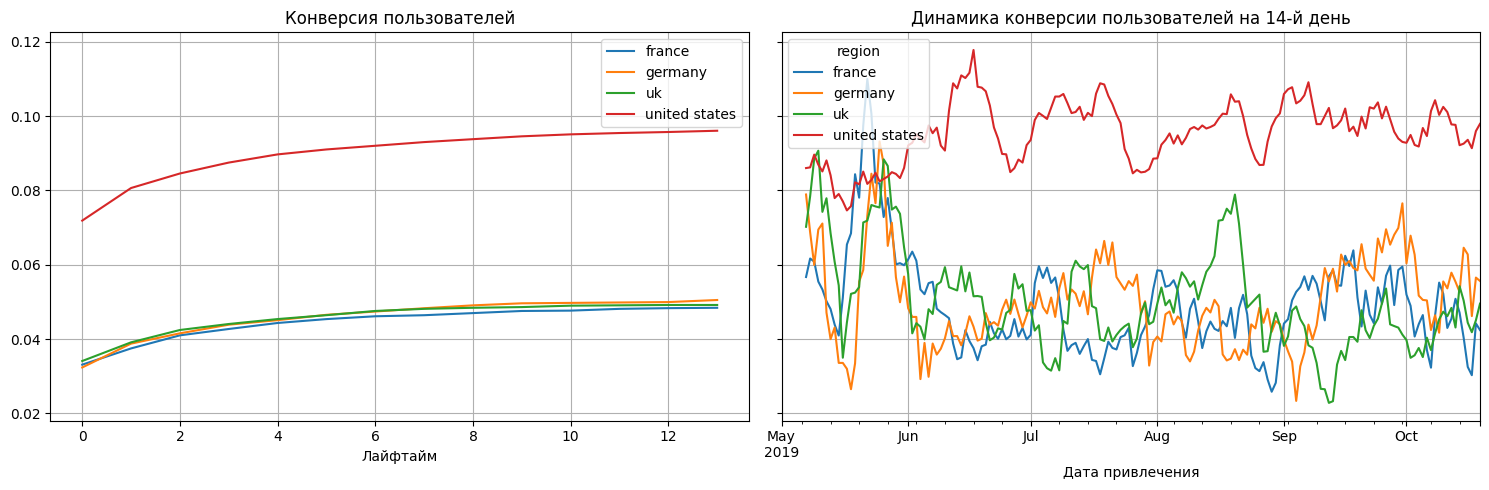

In [50]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

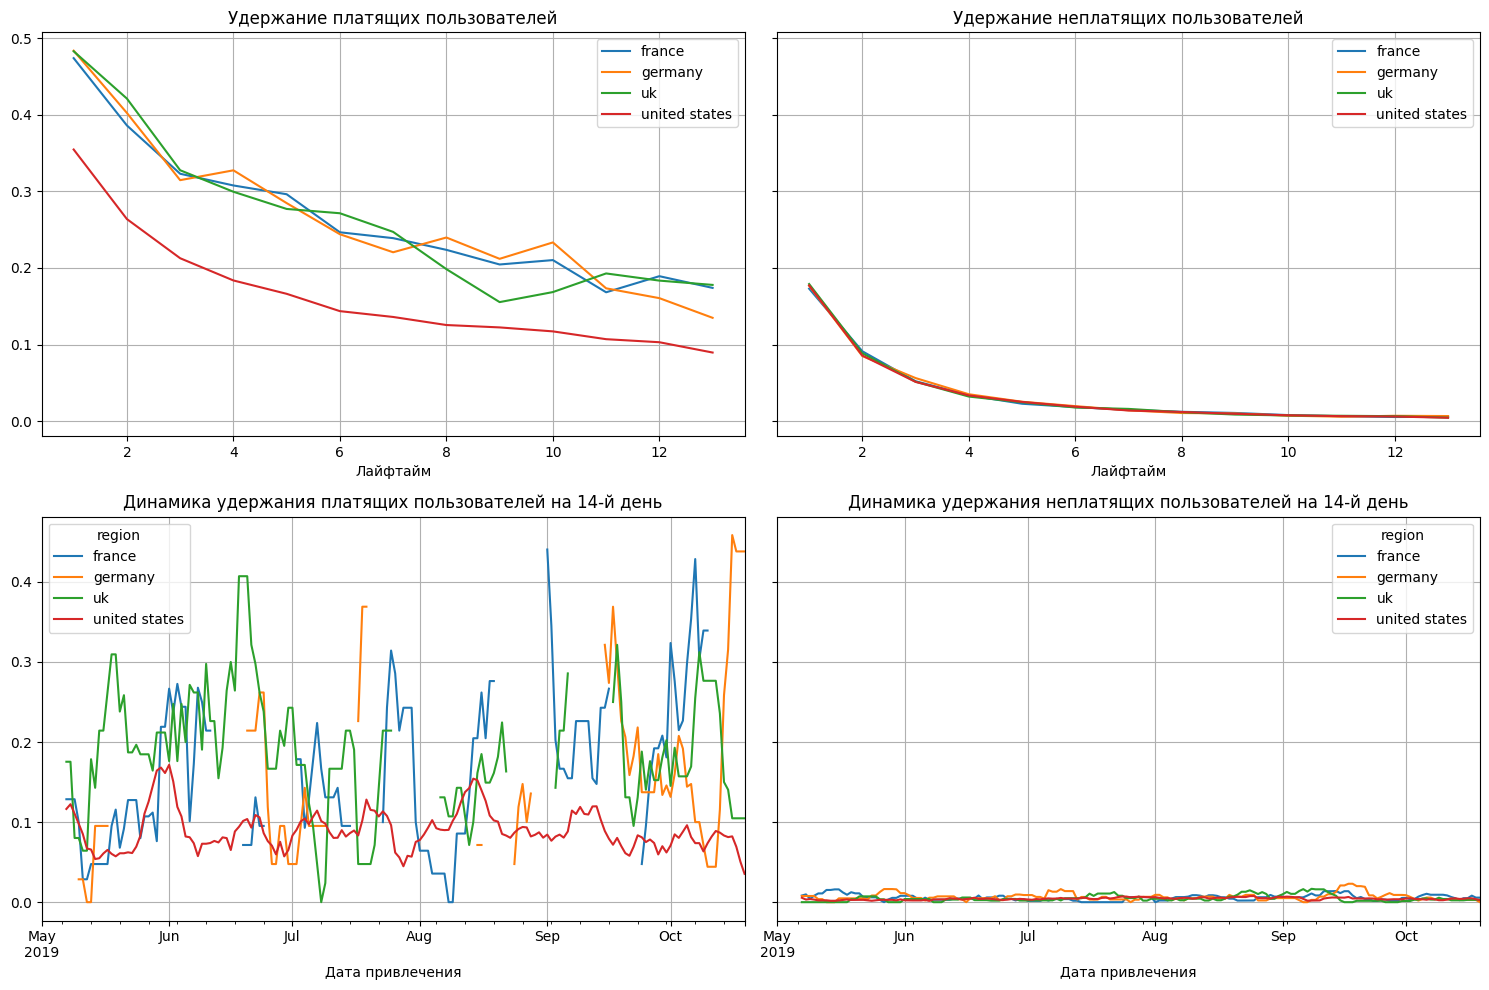

In [51]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

###### Вывод

Пользователи США хорошо конвертируются в плательщиков (значительно лучше, чем в трех других странах), удержание плательщиков из США в приложении значительно хуже чем в остальных странах. Американцам приложение нравится, они быстро начинают платить, но также быстро "остывают" к приложению и все реже в него возвращаются. 

Вследствие плохого удержания в США, компания вынуждена снова и снова тратить деньги в этом регионе на возврат пользователей или привлечение новых новых юзеров, которые еще не знаковы с приложением. Количество пользователей незнакомых с приложением постоянно сокращается, компании все сложнее до них "дотянуться" через рекламные каналы. Это ведет к росту расходов на привлечение пользователей.

###### Рекомендуем разработчикам сконцентрировать внимание на удержании в приложении пользователей из США. Это позволить сократить расходы на привлечение новых юзеров и тем сбалансировать экономику. 

#### Анализ окупаемости по каналам
Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

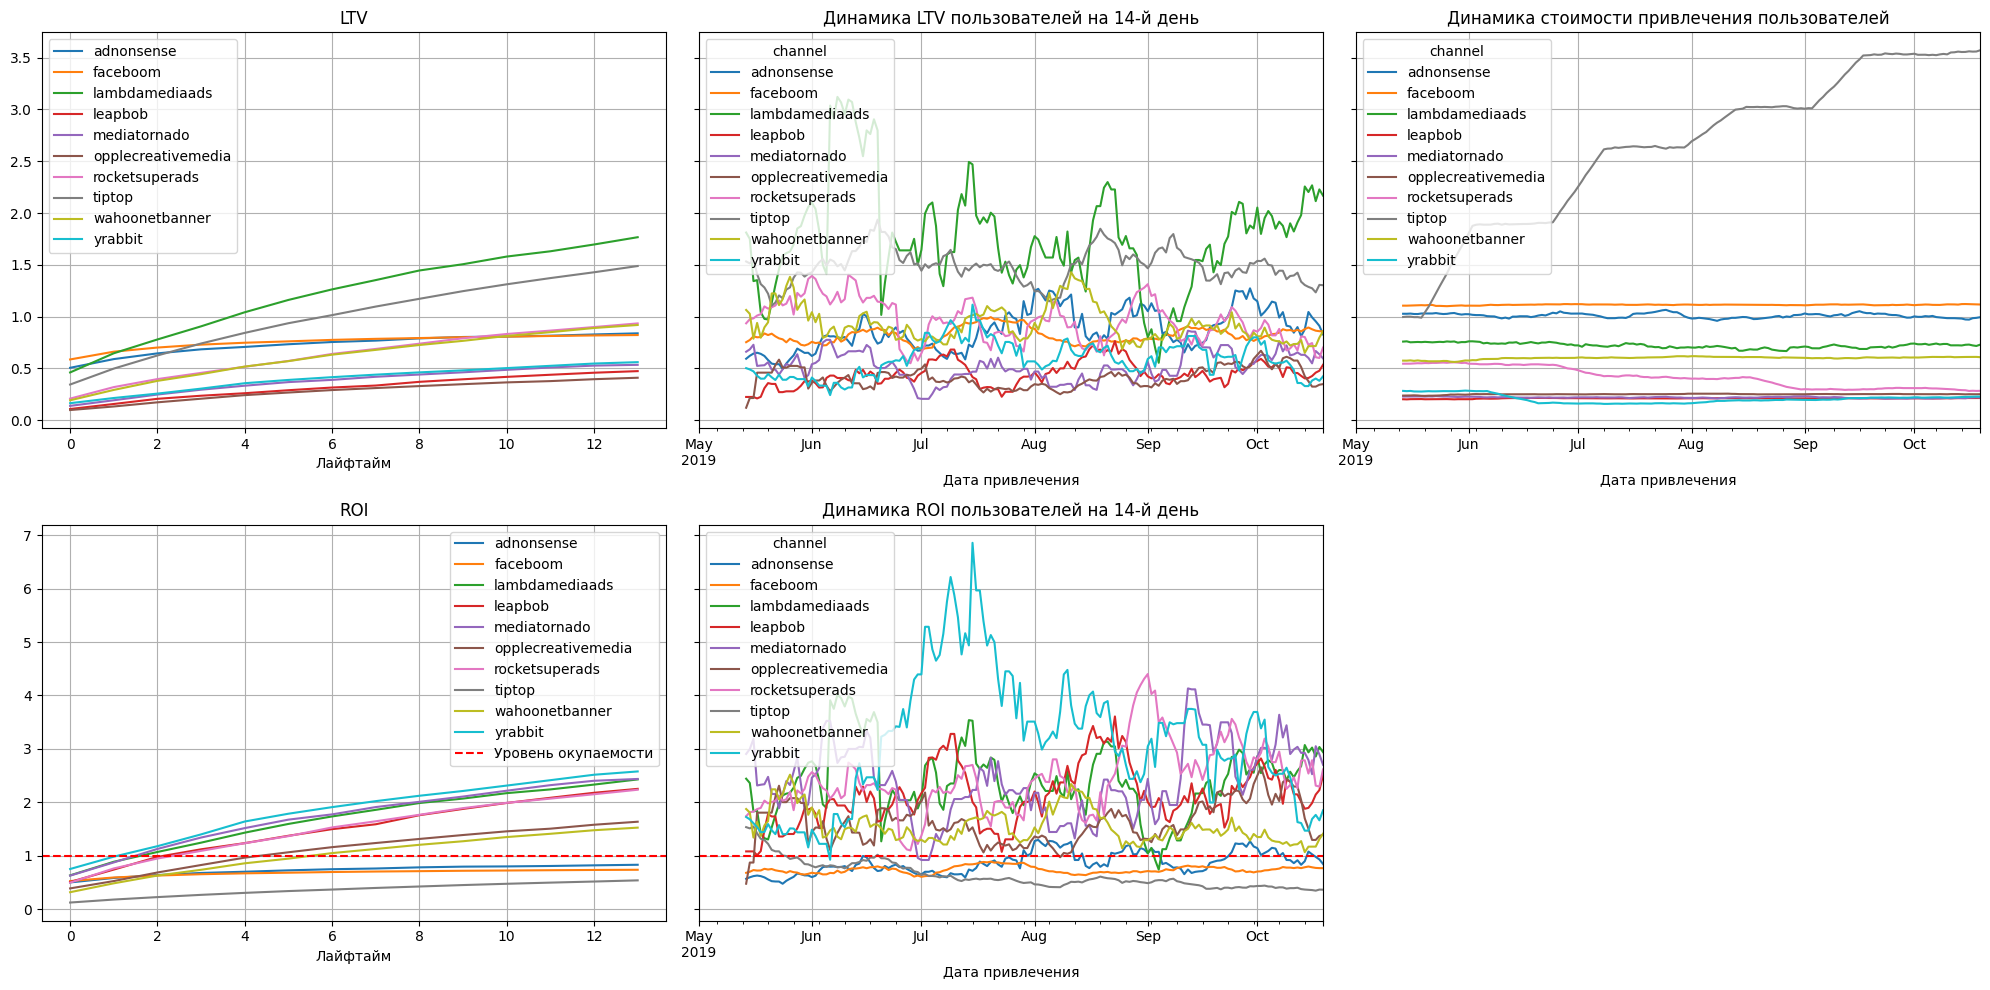

In [52]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

 ###### Вывод:
Самый высокий доход в течение своей жизни в приложении дают пользователи пришедшие из канала lambdamediaads. На втором месте по LTV канал tiptop.

Пользователи трех каналов - adnonsense, faceboom и tiptop - не окупаются за 14 дней. Эти же три канала имеют самую высокую стоимость привлечения юзеров. Если adnonsense и faceboom сохраняли в течение года стабильную цену САС, то tiptop демонстрирует аномальное поведение - скачкообразный рост САС в середины мая (резкий рост цены, затем нахождение на плато примерно месяц, далее снова резкий скачок цены и плато).

###### Рекомендация разработчикам - оптимизация САС для канала tiptop.

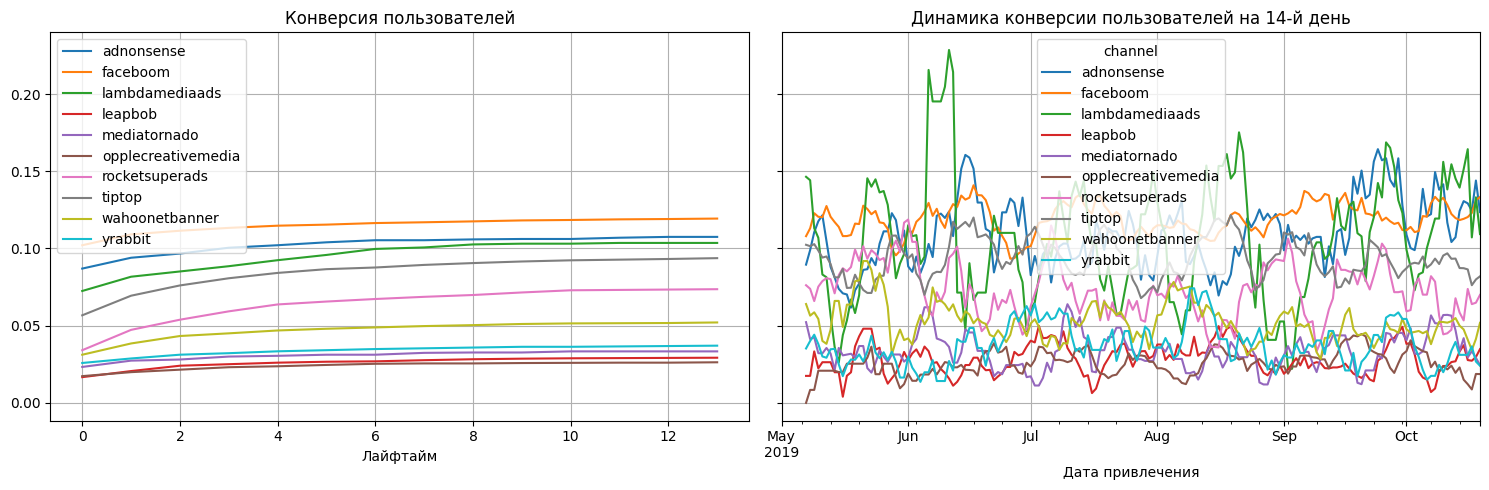

In [53]:
 # конверсия по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

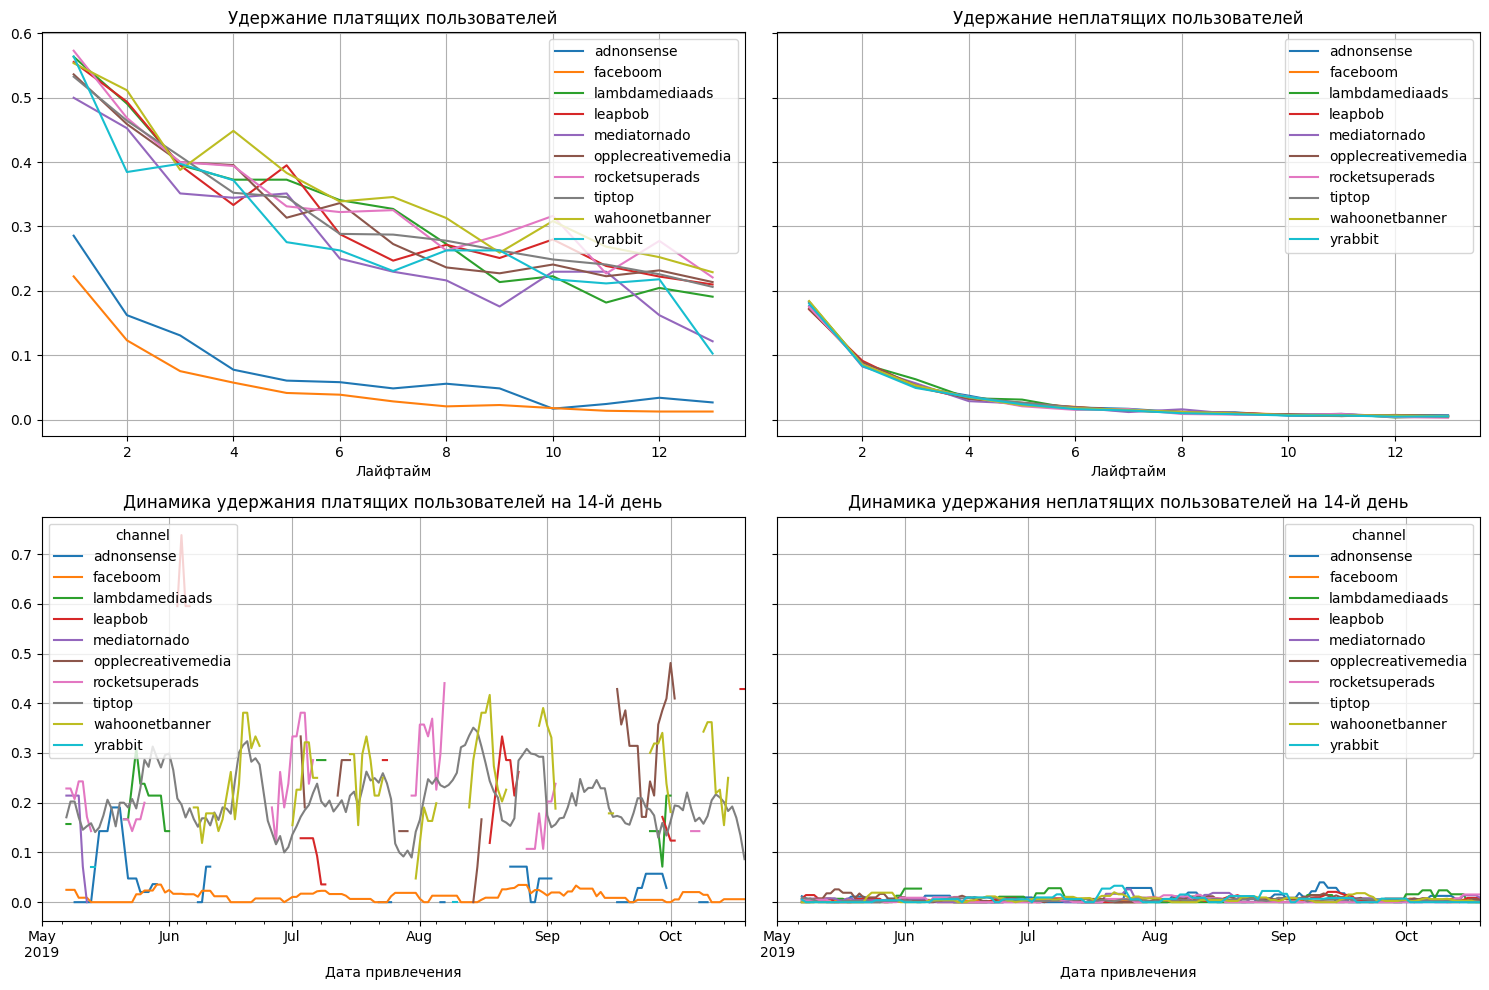

In [54]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

###### Вывод
Самая высокая конверсия (в порядке убывания) у пользователей faceboom, adnonsense, lambdamediaads и tiptop. Эти каналы перспективны. Однако графики их конверсии довольно пологие(не крутые), конверсия не достаточная. 

При этом faceboom, adnonsense демонстрируют самое худшее удержание плательщиков по сравнению с остальными каналами.

###### Учитывая анализ LTV, CAC и ROI по каналам, можно сделать следующие рекомендации:
* Оптимизировать САС для канала tiptop за счет увеличения конверсии пользователей. Если пользователи будут конверстироваться, то можно будет снизить расходы на привлечение новых.
* Для faceboom и adnonsense: во-первых, повысить удержание плательщиков, во-вторых - повысить конверсию пользователей в плательщиков. Стоимость привлечения в этих каналах стабильная, поэтому удержание и конверсия помогут увеличить прибыль с этих каналов. 

#### Анализ окупаемости по каналам в США

Из анализа выше вытекает различие в поведении американских и европейских пользователей. Поэтому для более корректного перераспределения потока рекламных ресурсов разделить пользователей на американских и европейских, проанализируем по отдельности окупаемость в разрезе рекламных источников. Построим конверсию и удержание по ним. 

Так получится более точно определить лидеров по показателям, то есть те каналы, на которые стоит перераспределить бюджет, каналы, которые помогут вывести кампанию на окупаемость.

In [55]:
# фильтруем профили пользователей - оставим только США 
edited_profiles_usa = edited_profiles.query('region != ["france", "germany", "uk"]')
edited_profiles_usa['region'].unique()

array(['united states'], dtype=object)

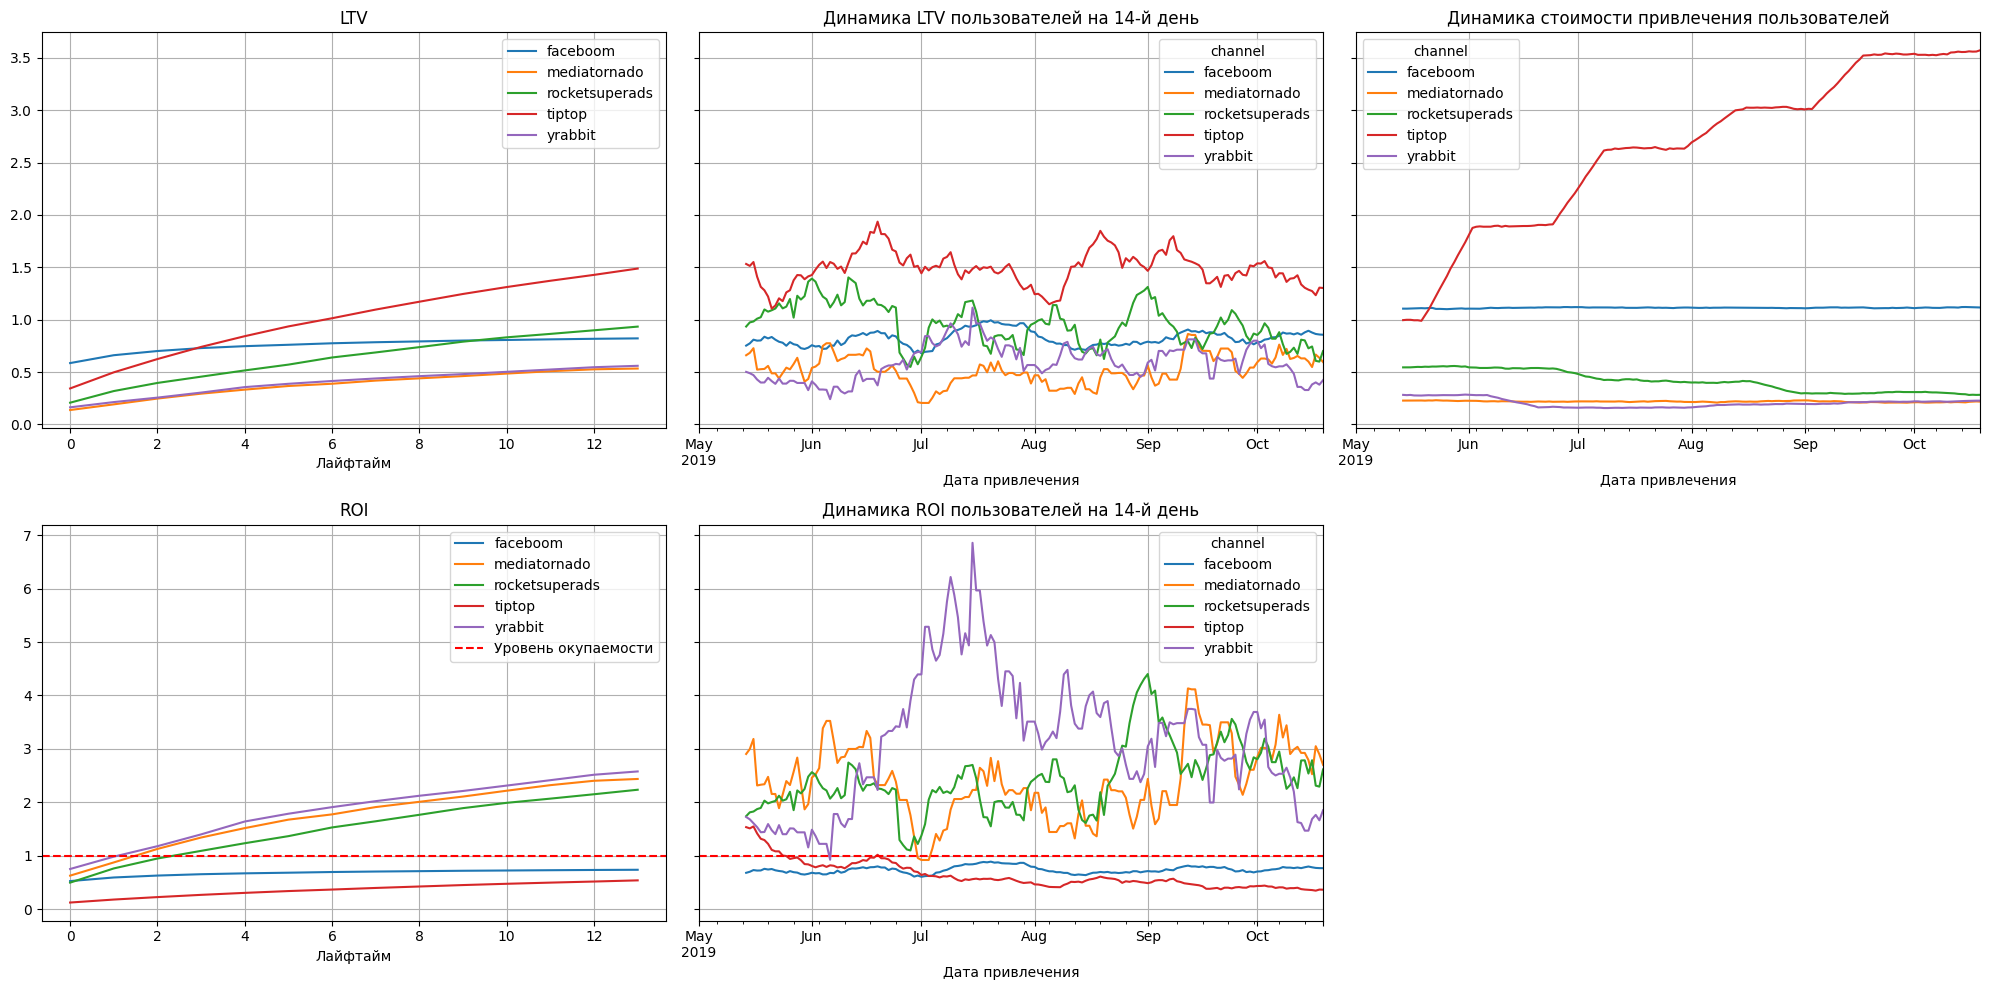

In [56]:
# окупаемость по каналам в США
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

###### Вывод
В США уже на 1-2 день окупаются каналы: yrabbit, mediatornado, rocketsuperads.

Каналы tiptop и faceboom не окупаются в течении 14 дней.

Tiptop имеет самый высокий пожизненный доход с пользователя, но и самый большой расход на привлечение. Поэтому становится убыточным.

У Faceboom стабильный (второй по величине после tiptop) САС, кривая LVT со 2 дня (лайфтайма) почти не растет. Предполагаем, что из Faceboomа приходит некачественная аудитория, которой не интересно приложение.

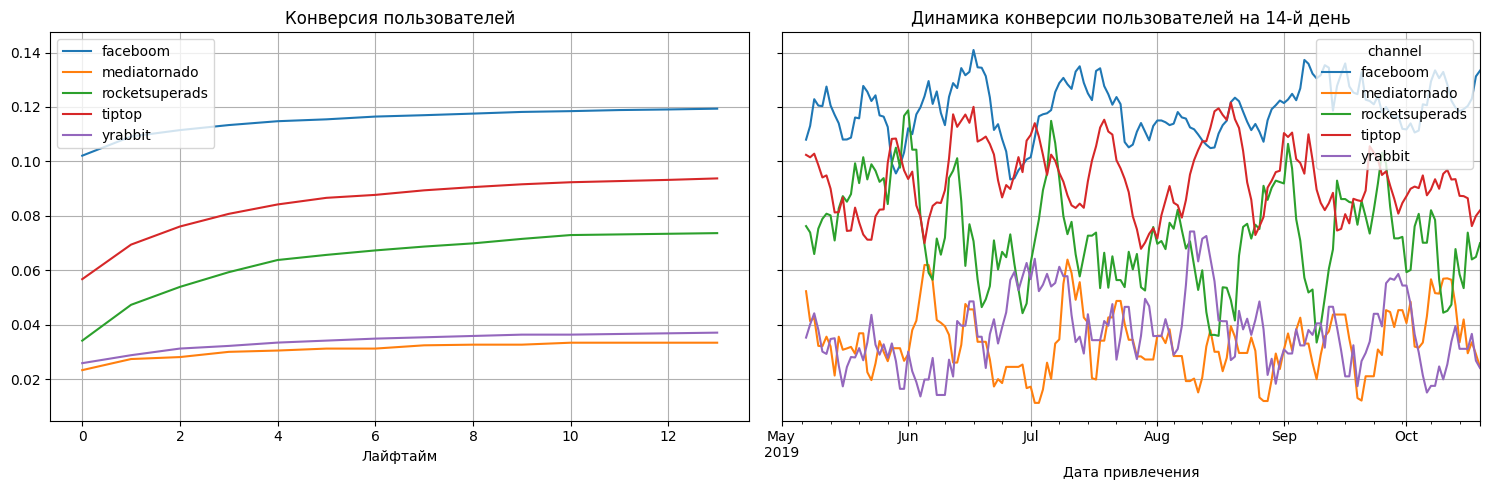

In [57]:
 # конверсия по каналам в США
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

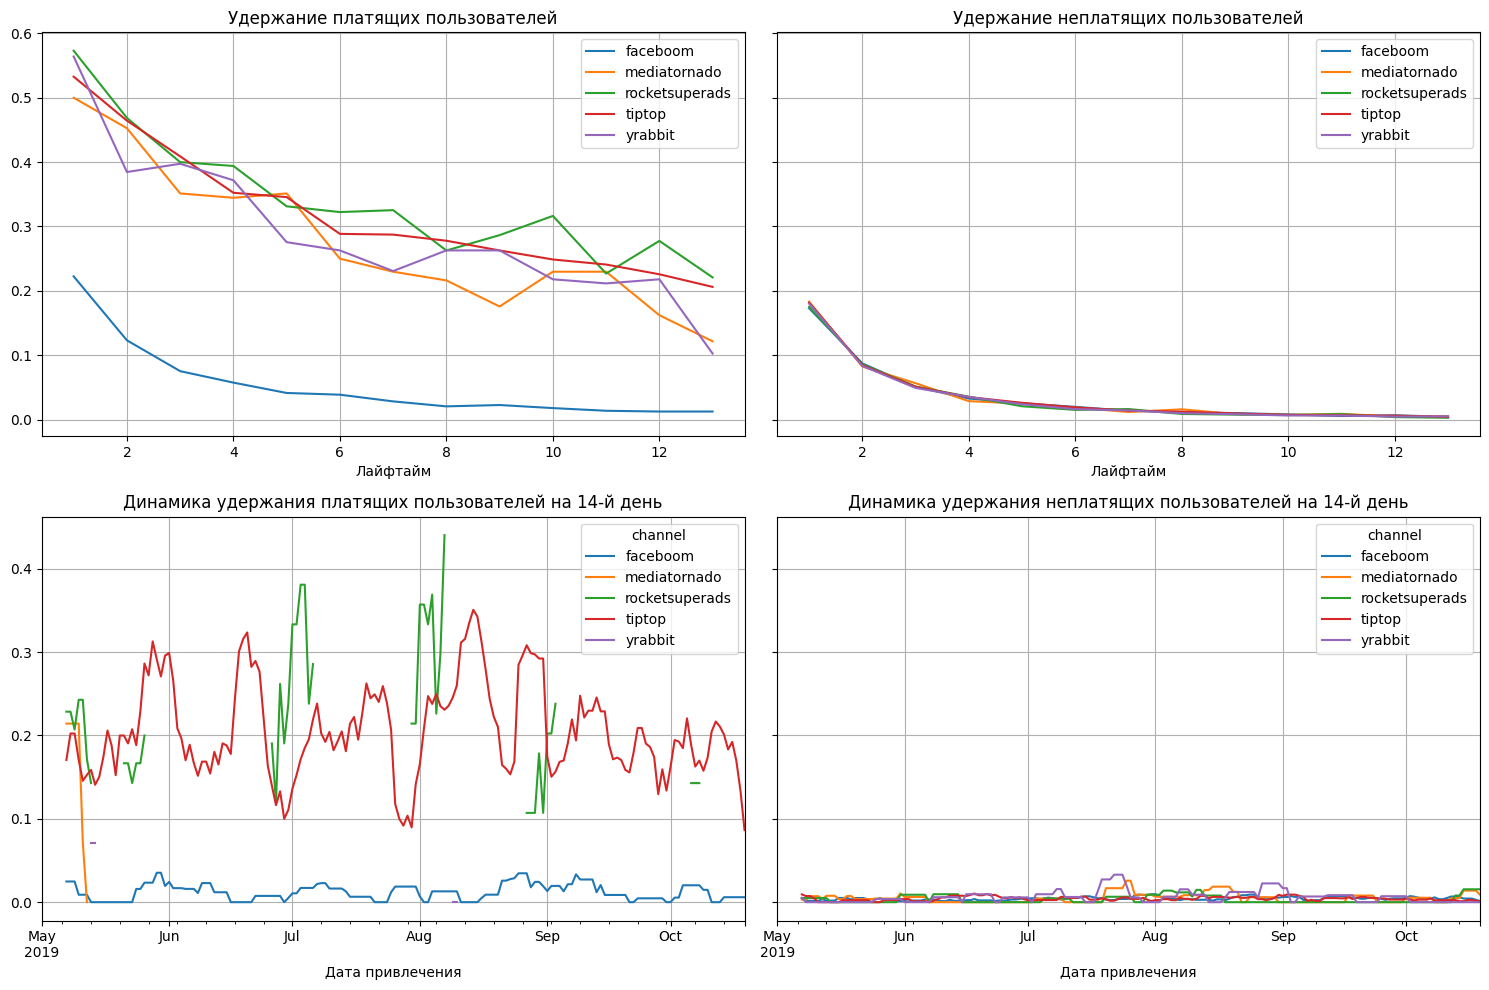

In [58]:
# удержание по каналам в США
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

In [64]:
# смотрим сколько в месяц расходуется на faceboom в США
edited_profiles_usa.query('channel == "faceboom"').groupby('month').agg({'acquisition_cost': ['sum']})

acquisition_cost
                        sum
month                      
2019-05-01           3524.4
2019-06-01           5501.1
2019-07-01           5294.3
2019-08-01           6274.4
2019-09-01           6114.9
2019-10-01           5736.5

###### Вывод
Самая высокая конверсия у faceboom, однако у него же и худшее удержание. 

У tiptop конверсия чуть хуже, чем у faceboom. Удержание на уровне остальных каналов (rocketsuperads, yrabbit, mediatornado).

###### Рекомендуем 
1. Сократить расходы на привлечения пользователей из faceboom в два раза, до 2500-3000. Из этого источника приходит не совсем качественная аудитория (низкий LTV, при стабильном САС, плохое удержание). Полностью отказываться от канала не нужно, все таки он дает 40% плательщиков. Возможно сокращение расходов позволит повысить его окупаемость. 

2. Для tiptop зафиксировать месячные расходы на привлечения на уровне faceboom (5000-6000 долл). Из этого канала приходит качественная аудитория (с лучшим LTV, хорошей конверсией и удержанием на уровне других соцсетей). Фиксация расходов приведет к сокращению количества новых пользователей, но это будут окупаемые юзеры.  

3. Высвободившиеся деньги распределить между rocketsuperad - 40% сэкономленного бюджета (тк у него лучший LTV, конверсия и удержание среди оставшихся каналов), и по 30% на yrabbit и mediatornado.

#### Анализ окупаемости по каналам в Европе

In [60]:
edited_profiles_europe = edited_profiles.query('region != "united states"')
edited_profiles_europe['region'].unique()

array(['germany', 'france', 'uk'], dtype=object)

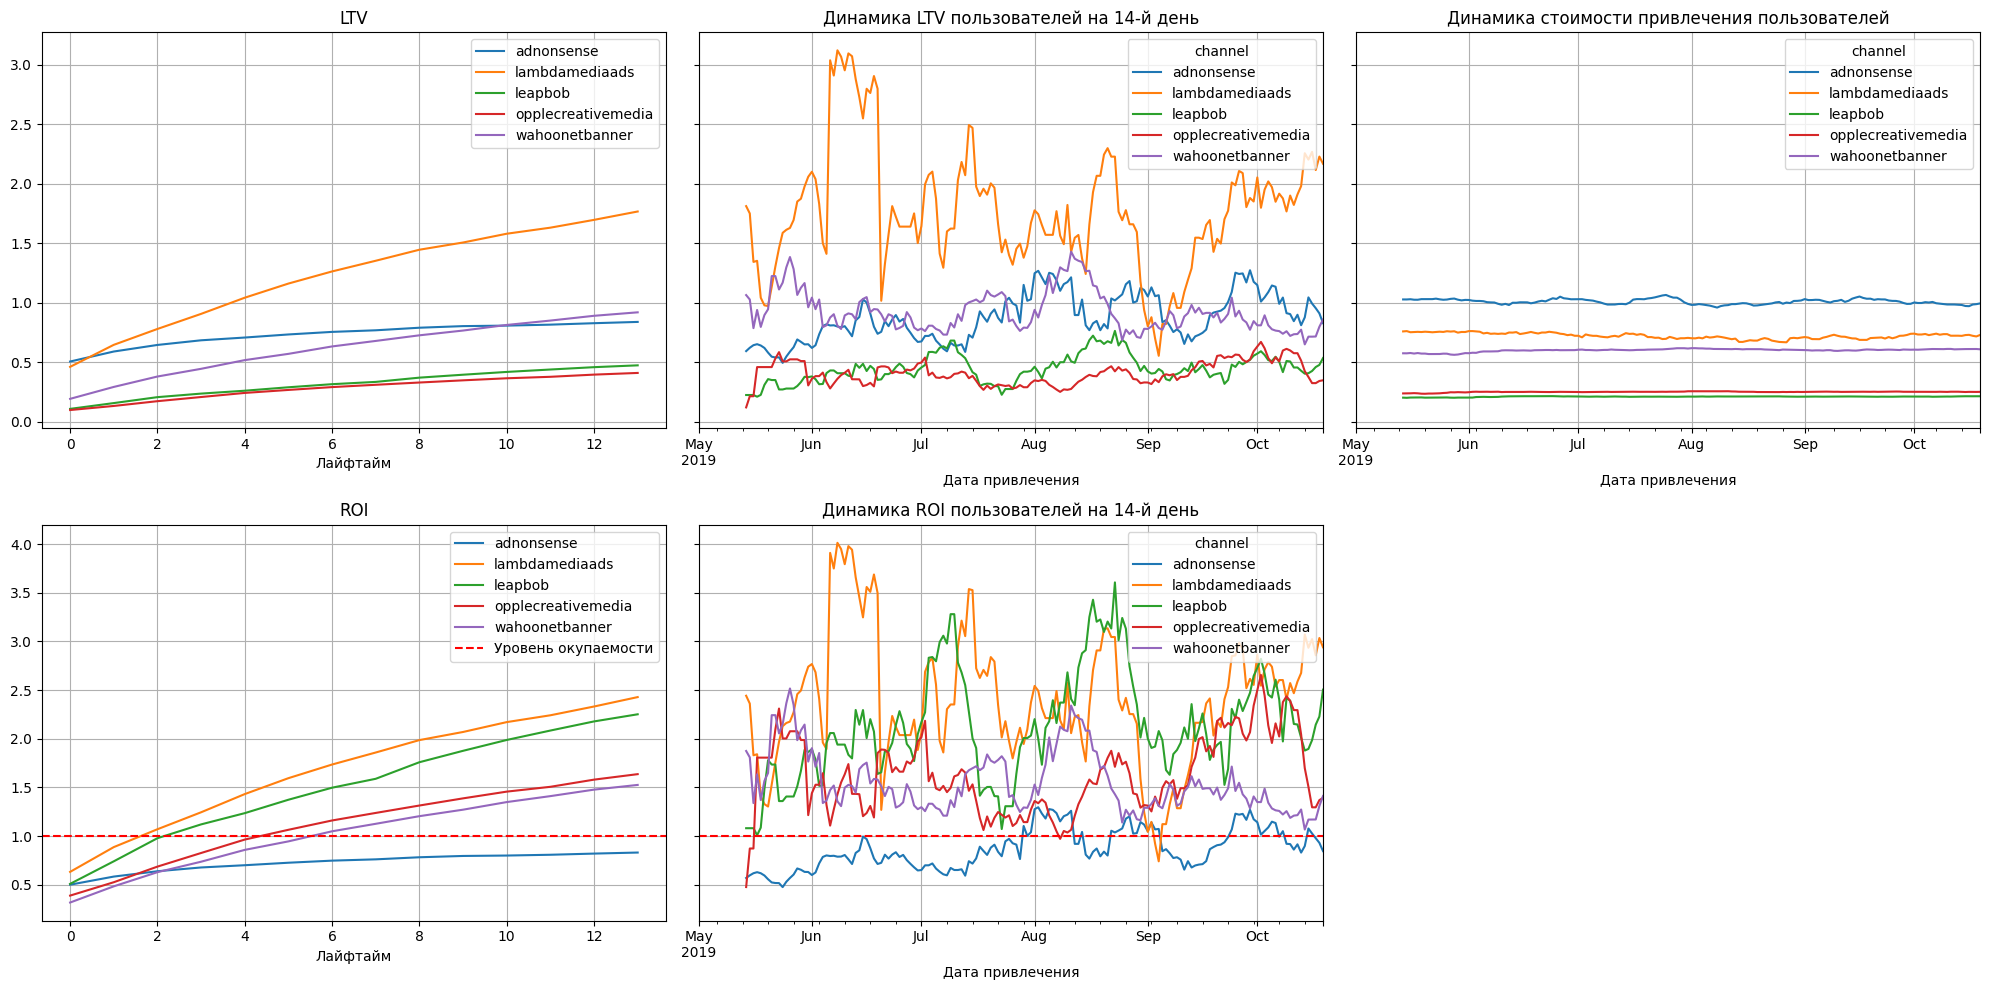

In [61]:
# окупаемость по каналам в Европе
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    edited_profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

###### Вывод
В Европейских странах за 14 дней не окупается канал adnonsense. Его расходы на привлечение выше, чем у остальных источников. Пользователи остальных каналов окупаются на 2-6 день. Лучший по LTV и ROI - lambdamediaads.


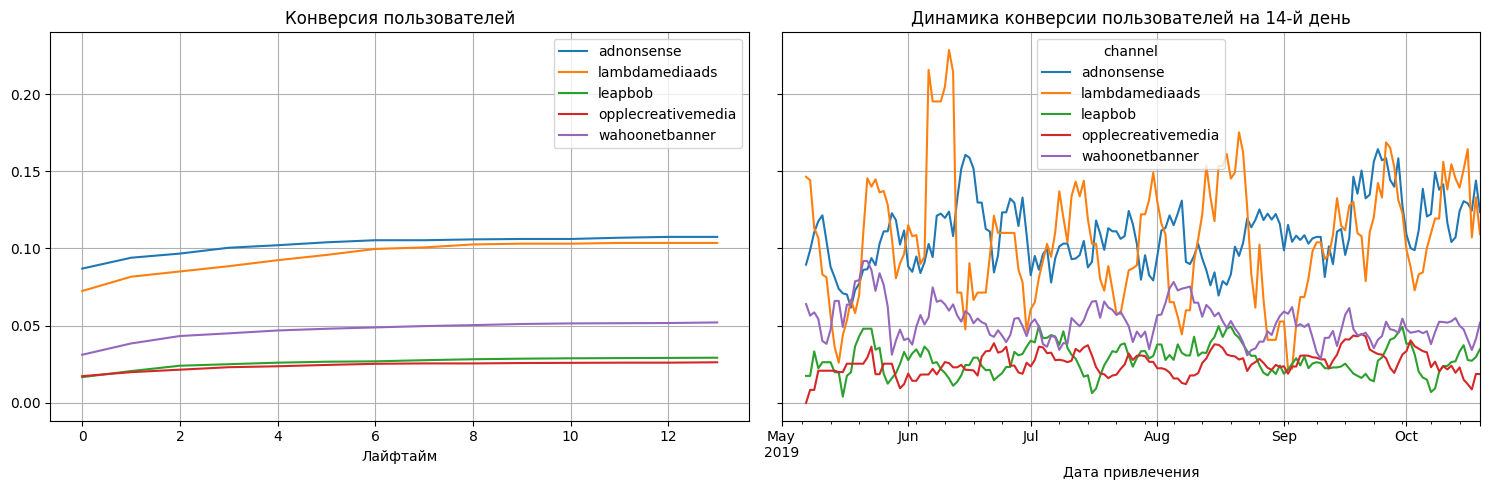

In [62]:
 # конверсия по каналам в Европе
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    edited_profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

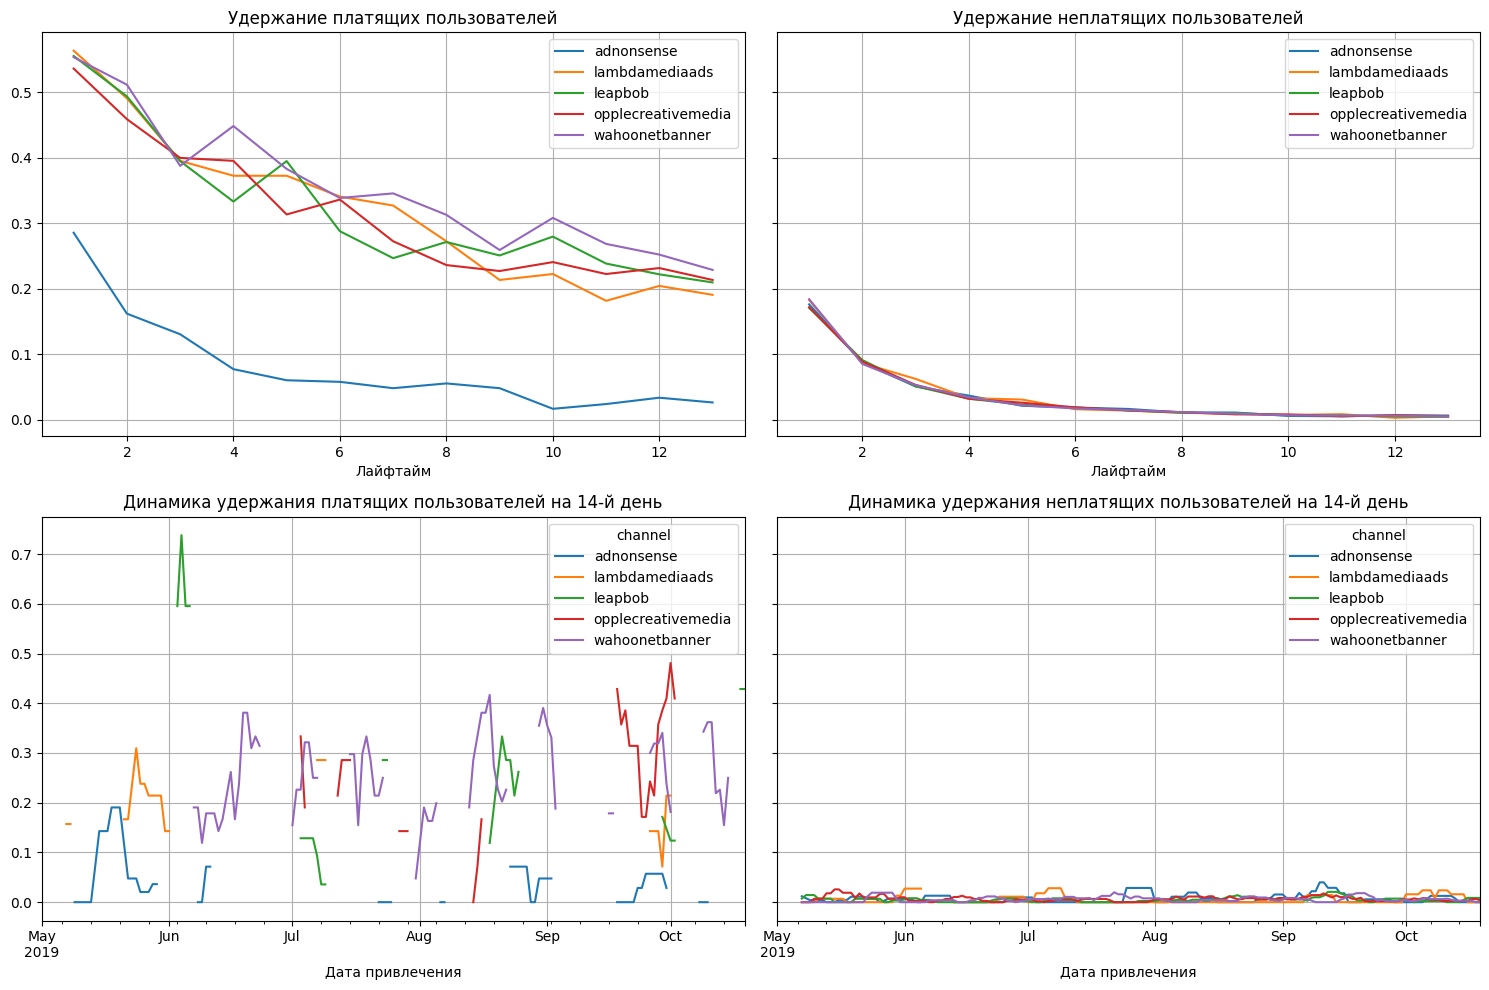

In [63]:
# удержание по каналам в Европе
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    edited_profiles_europe, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

In [66]:
# смотрим сколько в месяц расходуется на adnonsense в Европе
edited_profiles_europe.query('channel == "adnonsense"').groupby('month').agg({'acquisition_cost': ['sum']})

acquisition_cost
                        sum
month                      
2019-05-01           1169.4
2019-06-01            538.4
2019-07-01            504.3
2019-08-01            579.5
2019-09-01            581.6
2019-10-01            537.4

###### Вывод
Канал adnonsense имеет худшее удержание из всех европейских каналов, но лучшую конверсию (правда с 6 дня конверсия почти прекращается - график становится параллельным оси х). 

Вторая лучшая конверсия после adnonsense у канала lambdamediaads. 
Удержание в у каналов lambdamediaads, wahoonetbanner, leapbob, opplecreativemedia примерно одинаковое.

###### Рекомендации:
1. Сократить расходы на привлечение из adnonsense в два раза - до 250 долл в мес, высвобожденные деньги направить на  lambdamediaads (лучший LTV, ROI, хорошая конверсия и удержание).

2. Попытаться повысить ретеншен adnonsense (и других каналов). Например при помощи следующих форматов: начисление бонусов/ачивок за регулярное возвращение в приложение. Упростить онбординг (знакомство с приложением). Отправка уведомлений/советов как справиться с прокрастинацией, как наладить режим работы/отдыха. Добавить в приложение новую ценность/функции, например трекер задач. 

## Выводы

###### Причины неэффективности привлечения пользователей.

В целом можно сказать, что негативное влияние на окупаемость рекламы оказывают: по регионам - США, по устройствам - iphone, android и mac, по рекламным каналам - tiptop и faceboom. Теперь подробнее: 

1. Низкая диверсифицированность пользователей приложения по странам. Больше всего пользователей приложения (66,66%) и плательщиков (77,70%) - из США. На три другие страны приходится от 10-12% пользователей и от 7-8% плательщиков. Такое распределение ставит разработчиков в зависимость от психологических особенностей и пользовательских предпочтений юзеров из одной страны.


2. Высокая доля пользователей мобильных устройств iphone (36,22% всех пользователей и 38,08% всех платящих), android (23.35% пользователей и 23.08% плательщиков) и mac (20.03% всех пользователей,	21.53% всех плательщиков). При этом рользователи с устройствами Android, Mac и iPhone не окупаются в течении 14 дней из-за высокого САС.


3. Низкая конверсия в плательщиков пользователей, пришедших из органики (через самостоятельный поиск). Из органики в приложение приходят 37% пользователей, а апалельщиками становятся только 13%.


4. Два самых дорогих канала привлечения в США (faceboom и tiptop) не окупаются за 14 дней. Faceboom - 19.43% от всех пользователей приложения, 40.05% от всех плательщиков в приложении, tiptop - 13.04% от всех пользователей приложения, 21.15% плательщиков). При этом расходы tiptop составляют больше половины суммарных рекламных расходов приложения (54 751 долл, средняя стоимость привлечения одного пользователя 2.8 долл), еще примерно треть суммарных расходов приходится на faceboom (32445.6 долл, средний САС 1,11 долл). Данные расходы представляются завышенными.


5. В Европейских странах за 14 дней не окупается канал adnonsense.


###### Рекомендации для отдела маркетинга
(в порядке важности, в первую очередь нужно оптимизировать рекламные расходы в США):

1. Сократить расходы на привлечения пользователей из faceboom в два раза, до 2500-3000. Из этого источника приходит не совсем качественная аудитория (низкий LTV, при стабильном САС, плохое удержание). Полностью отказываться от канала не нужно, все таки он дает 40% плательщиков. Возможно сокращение расходов позволит повысить его окупаемость.


2. Для tiptop зафиксировать месячные расходы на привлечения на уровне faceboom (5000-6000 долл). Из этого канала приходит качественная аудитория (с лучшим LTV, хорошей конверсией и удержанием на уровне других соцсетей). Фиксация расходов приведет к сокращению количества новых пользователей, но это будут окупаемые юзеры.


3. Высвободившиеся деньги распределить между rocketsuperad - 40% сэкономленного бюджета (тк у него лучший LTV, конверсия и удержание среди оставшихся каналов), и по 30% на yrabbit и mediatornado.


4. В Европе сократить расходы на привлечение из adnonsense в два раза - до 250 долл в мес, высвобожденные деньги направить на lambdamediaads (лучший LTV, ROI, хорошая конверсия и удержание).


5. Для faceboom в США и adnonsense в Европе: во-первых, повысить удержание плательщиков. Например при помощи следующих форматов: начисление бонусов/ачивок за регулярное возвращение в приложение. Отправка уведомлений/советов как справиться с прокрастинацией, как наладить режим работы/отдыха. Добавить в приложение новую ценность/функции, например трекер задач.
Во-вторых - повысить конверсию пользователей в плательщиков (пробный период, упростить онбординг/знакомство с приложением). Стоимость привлечения в этих каналах стабильная, поэтому удержание и конверсия помогут увеличить прибыль с этих каналов.


6. Попробовать нативную медийную рекламу для повышения органического (поискового) притока пользователей. Сейчас 37% пользователей приходят из органики. Повышение исзвестности может увеличить эту долю. Например, можно опубликовать на развлекательных сайтах/блогах материалы о способах контроля програстинации, где рассказать в том числе про возможности приложения.
 
 
7. Оптимизировать стоимость привлечения на устройствах Android, Mac и iPhone. Снижение стоимости привлечения на этих устройствах позволит добиться целевой окупаемости пользователей этих источников в течении 14 дней. 


8. Увеличить долю пользователей приложения в Великобритании, Германии, Франции и других странах. Это можно сделать за счет перераспределения ресурсов сэкономленных при оптимизации рекламных каналов в США.